# Notebook configuration

In [45]:
run_numbers   = 4520, 4527, 4529, 4531, 4534, 4539, 4547, 4549, 4551
save_plots    = False
plots_format  = "png"
outputfolder  = "plots/{}/".format("na_multirun")
corr_filename = "run{}_corrections.h5".format(4446)
inputfilename = "/Users/Gonzalo/github/NEXTdata/Na22/dst_{}.root.h5"

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 15e3
Erange_zcorr  =     0, 15e3
Erange_xycorr =   6e3, 12e3
Qrange        =     0, 10e2
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-2, 1e-1

NSirange      =     0, 30

Zrange_DV     =   545, 555
Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan

# Kr analysis

In [46]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  . dst_io        as dstio
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma as poisson_uncertainty
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder, plots_format) if save_plots else lambda *x: None

Running on  Sat Aug 19 16:30:17 2017


#### General plotting options

In [47]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 12, 9
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [48]:
full = dstio.load_dsts([inputfilename.format(run) for run in run_numbers], "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

444610


event          time  peak  nS2    S1w        S1h         S1e       S1t  \
0      1  1.500371e+09     0    1  175.0  25.080278  123.319018  200125.0   
2      3  1.500371e+09     0    1  200.0  15.560621   85.379706  200125.0   
3      4  1.500371e+09     0    1  150.0   9.811378   46.989243  200100.0   
4      5  1.500371e+09     0    1  125.0   7.531867   32.424671  200100.0   
5      6  1.500371e+09     0    1  150.0   9.752417   46.730792  200125.0   

         S2w           S2h    ...           S2t  Nsipm        DT         Z  \
0  25.201250  16910.757812    ...      376112.5    120  175.9875  175.9875   
2  20.776875  15982.678711    ...      350162.5     87  150.0375  150.0375   
3   9.103563  11846.042969    ...      362187.5     49  162.0875  162.0875   
4  20.979375   2610.416504    ...      368337.5     33  168.2375  168.2375   
5  12.138188   7612.934082    ...      420112.5     37  219.9875  219.9875   

            X          Y           R       Phi       Xrms       Yrms  
0   -9.922687  -3.392437   10.486579 -2.812164  22.661728  28.660432  
2 -123.604512   4.272636  123.678336  3.107039  20.367255  21.109760  
3   28.270247 -32.568829   43.126970 -0.855936  20.628129  24.554798  
4 -195.420528  -4.320839  195.468290 -3.119486  12.012299  10.906860  
5  -86.106461 -81.994585  118.900945 -2.380650  12.334432  10.974761  

[5 rows x 22 columns]

In [49]:
XYcorr = dstf.load_xy_corrections(corr_filename)

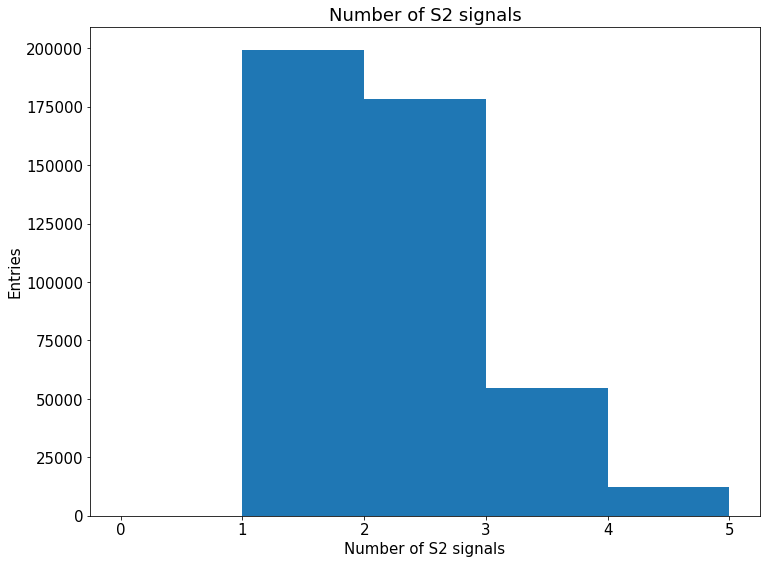

In [50]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

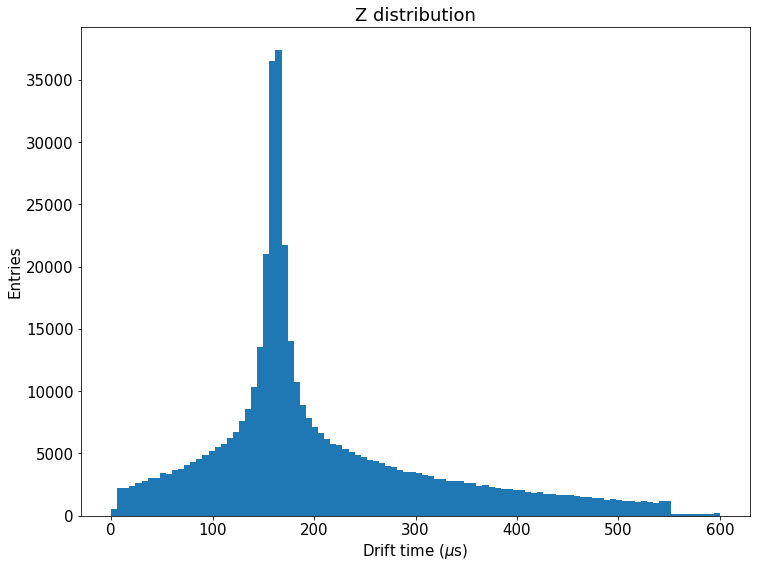

In [51]:
hist(full.Z, 100, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

T1/2 = 22.64 +- 1.61 y


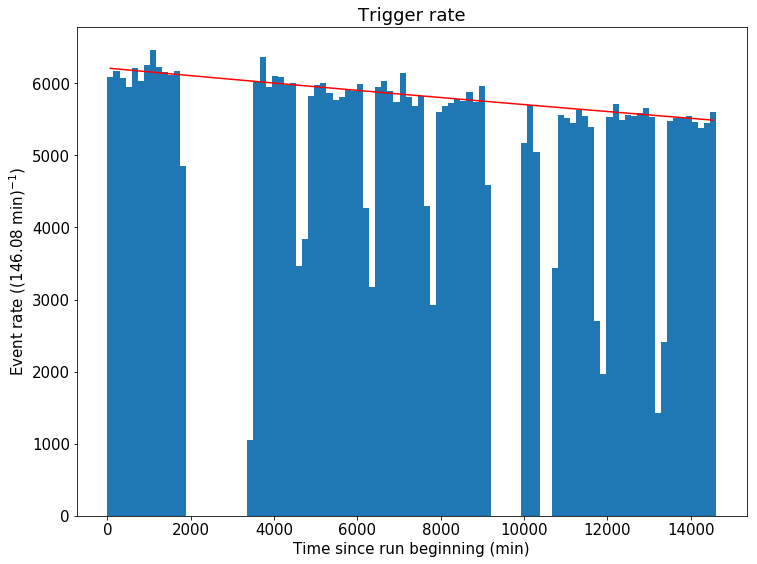

In [52]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _  = hist(T, 100, (np.min(T), np.max(T)))
bin_size = np.diff(x)[0]

sel = y > 5500
f = fitf.fit(fitf.expo, x[sel], y[sel], (6e3, -1e4), sigma=poisson_uncertainty(y[sel]))

plt.plot(x, f.fn(x), fitOpt)
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(bin_size),
       "Trigger rate")
save("EventRate")

scale = np.log(2)*bin_size/60/24/365.25
print("T1/2 = {:.2f} +- {:.2f} y".format(-f.values[1]*scale, f.errors[1]*scale))

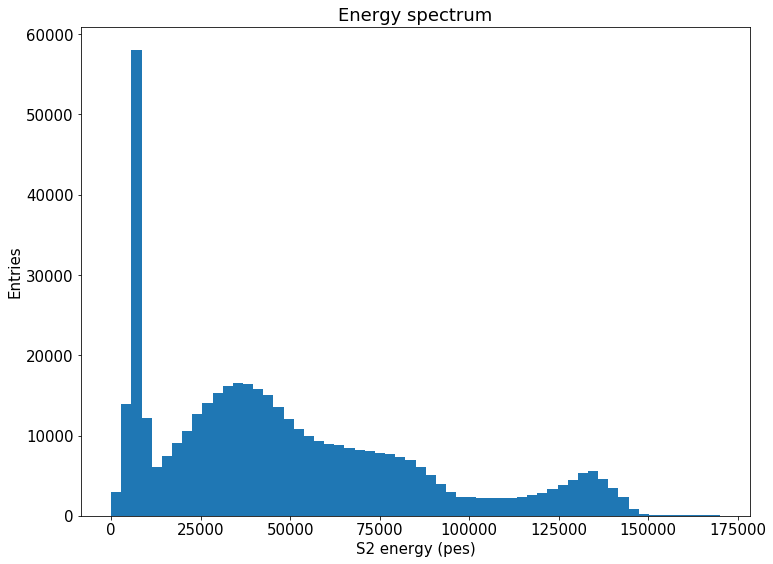

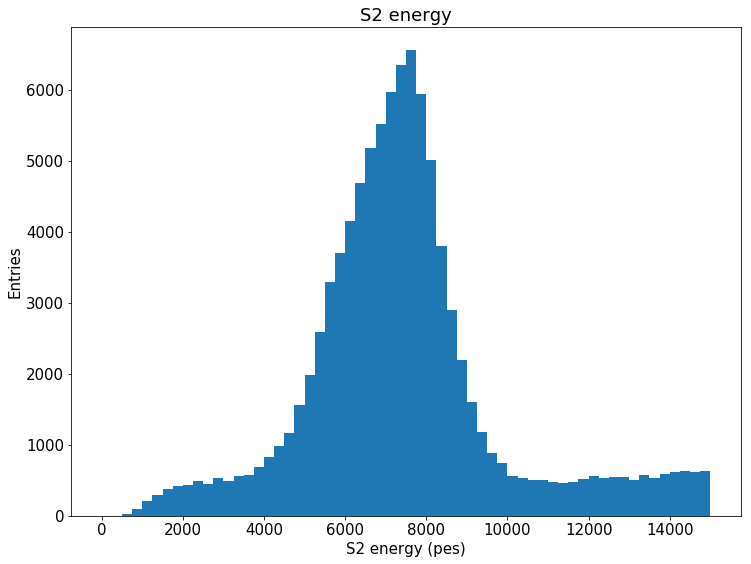

In [53]:
hist(full.S2e, 60, (0, 170e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

# S2 energy

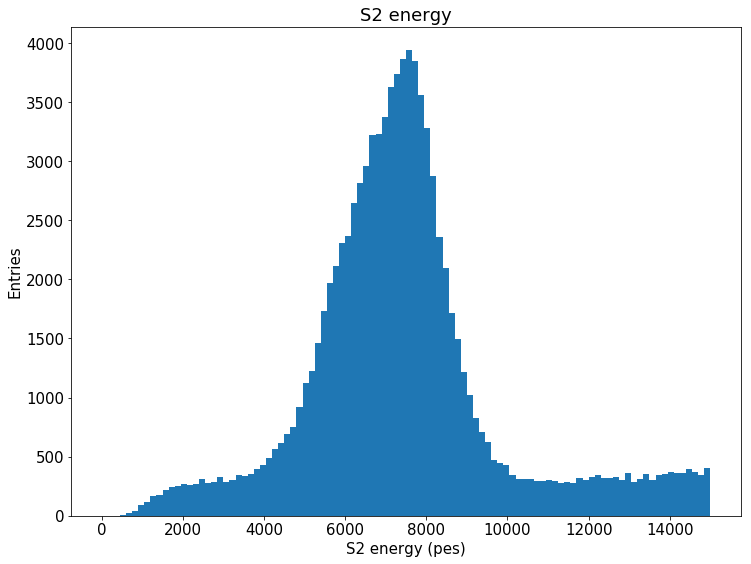

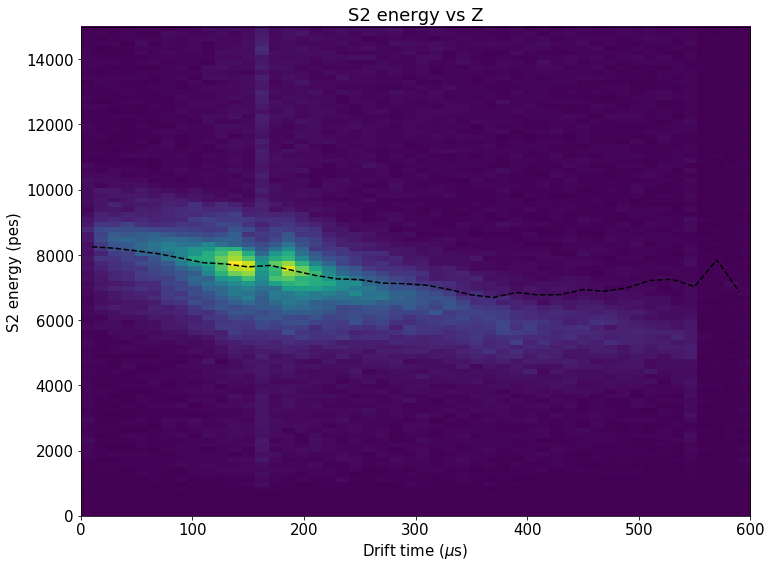

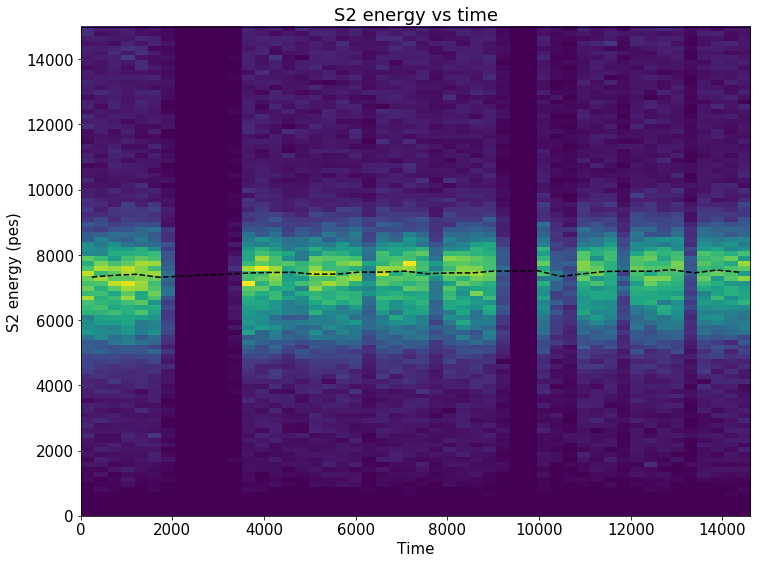

In [54]:
hist(full.S2e, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

hist2d(T, full.S2e, (50, 100), range=((0,np.max(T)), Erange_raw))
x, y, _ = fitf.profileX(T, full.S2e, 30, xrange=(0,np.max(T)), yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Time", "S2 energy (pes)", "S2 energy vs time")
save("S2energyvsZ")

# Lifetime calculation

In [55]:
fid = full
fid = fid[fid.R < 100] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.3252018623062909


event          time  peak  nS2    S1w        S1h         S1e       S1t  \
0       1  1.500371e+09     0    1  175.0  25.080278  123.319018  200125.0   
3       4  1.500371e+09     0    1  150.0   9.811378   46.989243  200100.0   
6       7  1.500371e+09     0    2  175.0   7.341968   43.901282  200150.0   
11     10  1.500371e+09     0    1  275.0  24.501719  139.344720  200100.0   
12     11  1.500371e+09     0    2  200.0  19.836926  100.596031  200100.0   

          S2w           S2h    ...           S2t  Nsipm        DT         Z  \
0   25.201250  16910.757812    ...      376112.5    120  175.9875  175.9875   
3    9.103563  11846.042969    ...      362187.5     49  162.0875  162.0875   
6    8.600000  11427.326172    ...      359787.5     33  159.6375  159.6375   
11  24.819844  11217.376953    ...      361062.5     93  160.9625  160.9625   
12  23.017500  11519.499023    ...      353637.5     90  153.5375  153.5375   

            X          Y          R       Phi       Xrms       Yrms  
0   -9.922687  -3.392437  10.486579 -2.812164  22.661728  28.660432  
3   28.270247 -32.568829  43.126970 -0.855936  20.628129  24.554798  
6  -49.932229   1.097235  49.944284  3.119622  10.891991  10.950608  
11 -45.506359   3.502096  45.640918  3.064786  19.141062  22.470709  
12 -42.141197  -2.644207  42.224072 -3.078928  21.217653  21.410031  

[5 rows x 22 columns]

# S2 energy fiducialized

Energy at z=0 = 9291.3 +- 28.1
Lifetime      = 1085.0 +- 16.4
Chi2          = 1.91          


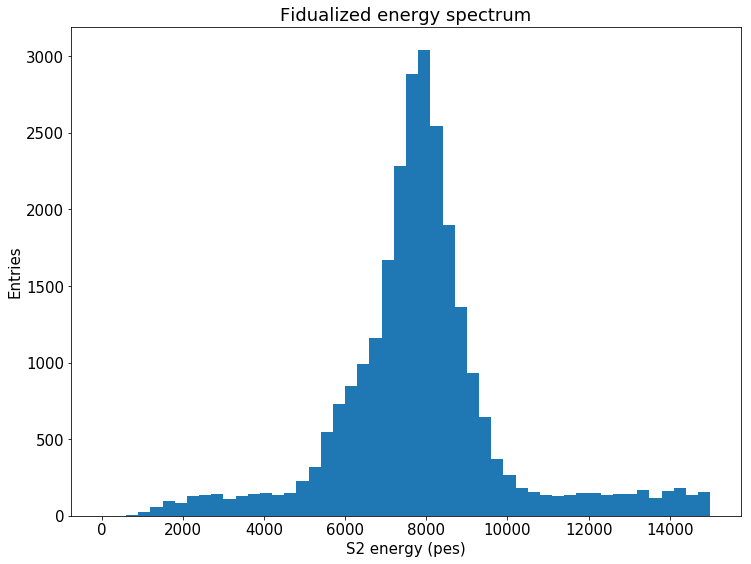

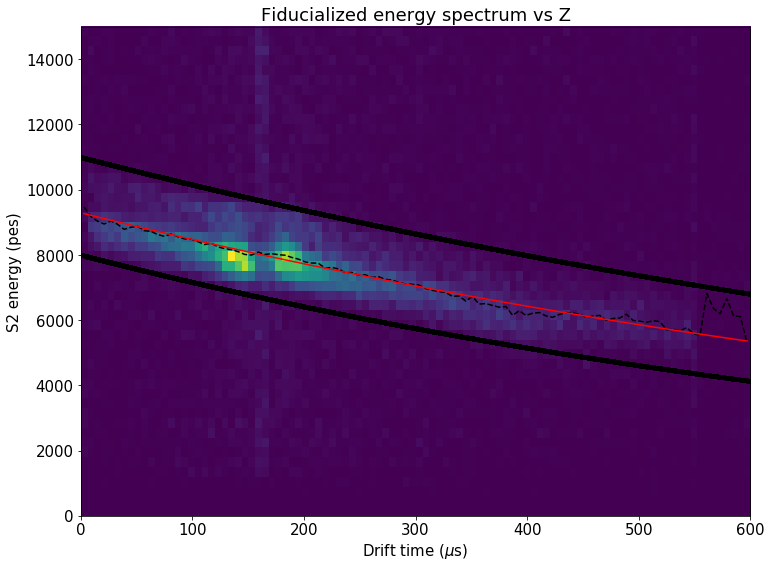

In [56]:
hist(fid.S2e, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")

low_cut   =  8000 * np.exp(-0.0011*fid.Z.values)
high_cut  = 11000 * np.exp(-0.0008*fid.Z.values)
sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, Erange_raw))
x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], 100, xrange=Zrange, yrange=Erange_raw)

plt.plot(x, y, profOpt)
plt.plot(fid.Z.values,  low_cut, "k.")
plt.plot(fid.Z.values, high_cut, "k.")

seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

# Lifetime dependence

Lifetime =  (1093.4 +- 16.4) - (0.220 +- 0.157) x exp[x/(457149461.8 +- 406922514028336.8)]
Chi2 = 0.420668858866


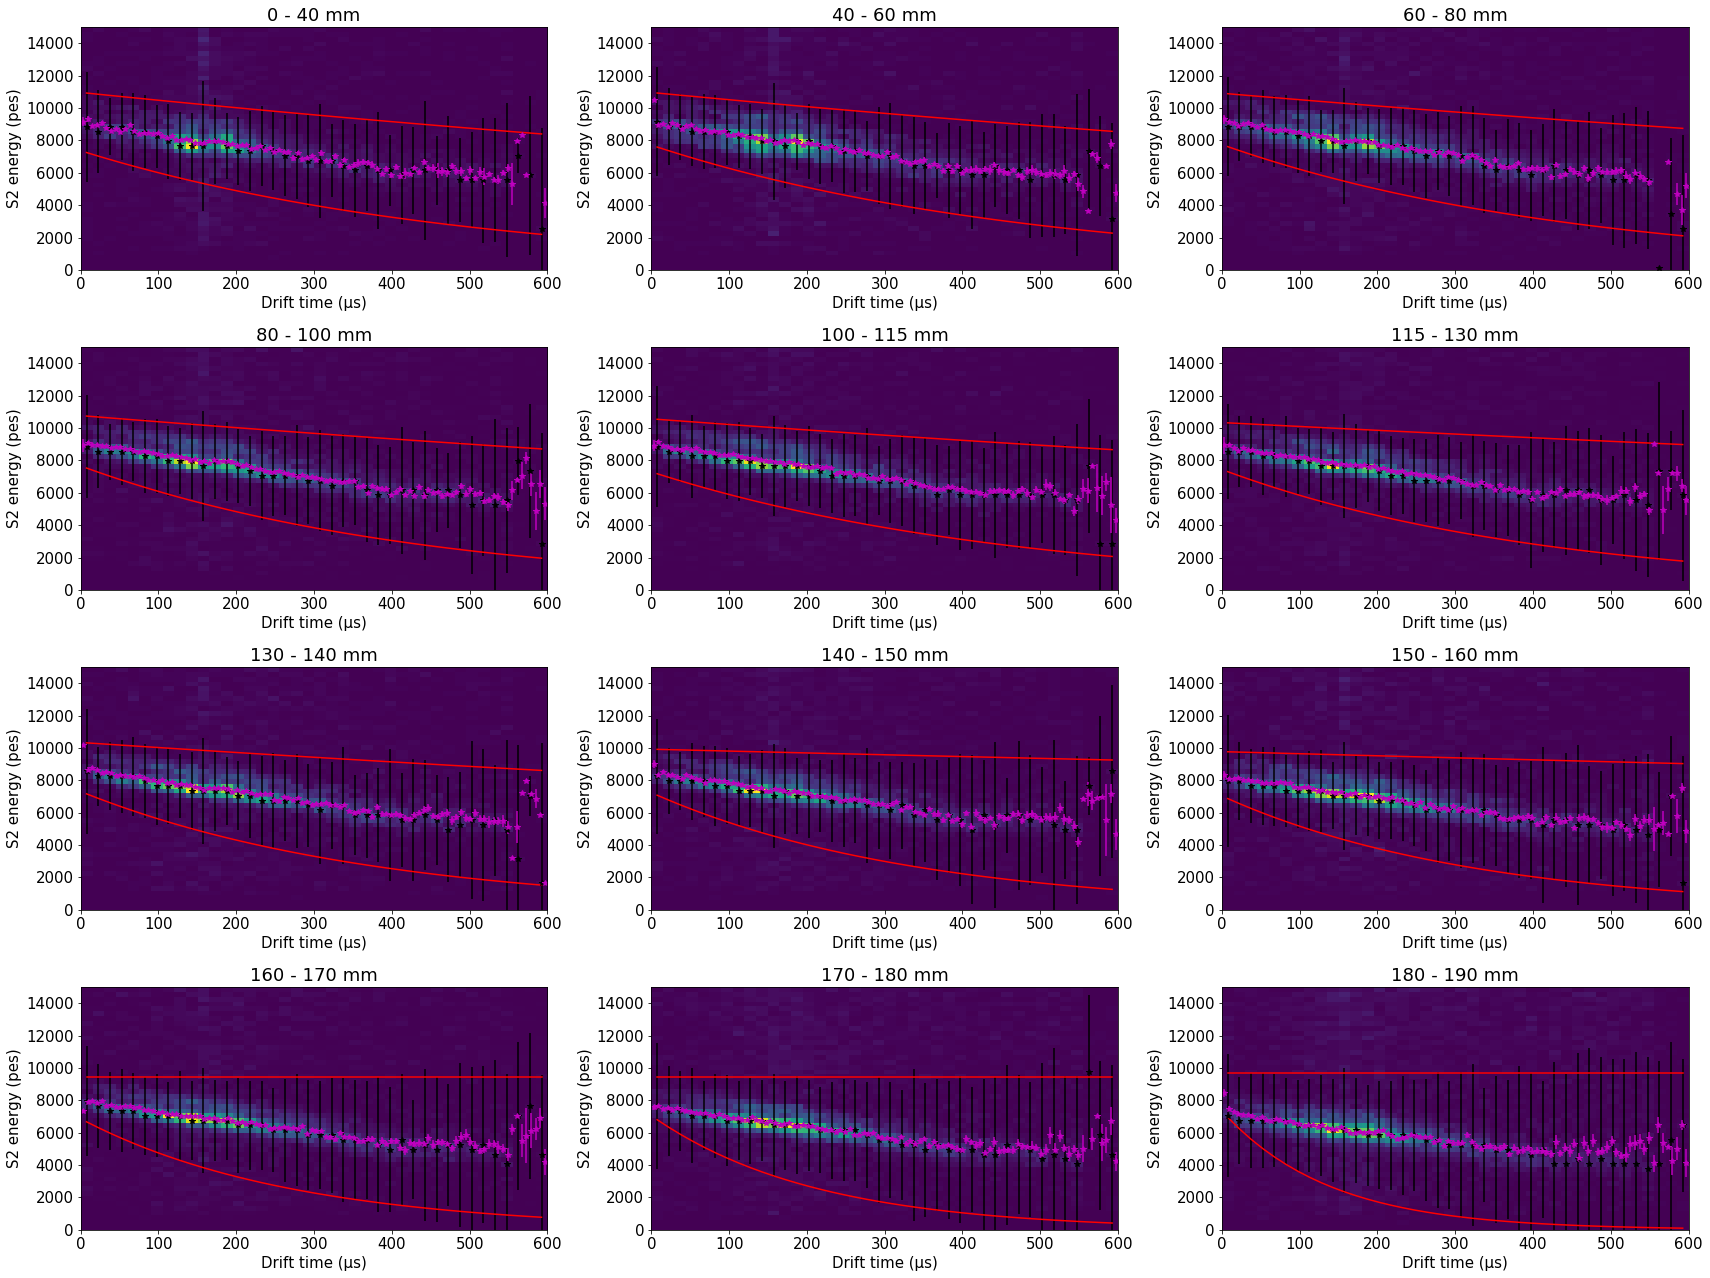

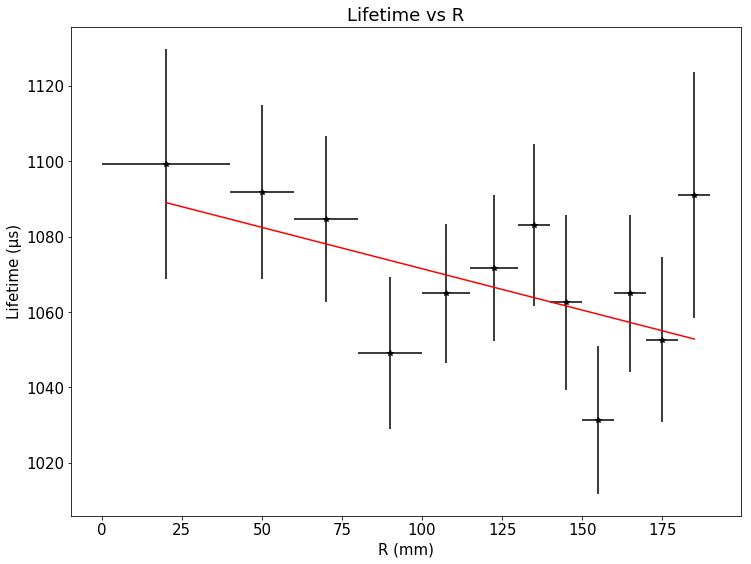

In [57]:
rbins  = np.array([0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190])
nbins  = len(rbins) - 1
nx, ny = 4, 3

LT     = np.zeros(nbins)
u_LT   = np.zeros(nbins)

Z = full.Z  .values
R = full.R  .values
E = full.S2e.values

plt.figure(figsize=(6*nx, 6*ny))

for i in range(nbins):
    sel_r = coref.in_range(E, *Erange_raw) & coref.in_range(R, *rbins[i:i+2])
    
    plt.subplot(nx, ny, i+1)
    n, x, y, _ = \
    hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
    labels("Drift time (µs)", "S2 energy (pes)", "{:.0f} - {:.0f} mm".format(*rbins[i:i+2]))
    slice_max = np.argmax(n, axis=1)
    slice_ene = y[slice_max]
    slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]
    
    plt.errorbar(x, slice_ene, slice_rms, fmt="*k")
    
    f_low = fitf.fit(fitf.expo, x, slice_ene-slice_rms, (1e4, -500), fit_range=Zrange_LT)
    f_upp = fitf.fit(fitf.expo, x, slice_ene+slice_rms, (1e4, -500), fit_range=Zrange_LT)
    
    plt.plot(x, f_low.fn(x), "r")
    plt.plot(x, f_upp.fn(x), "r")

    low_cut = f_low.fn(Z)
    upp_cut = f_upp.fn(Z)
    sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)
    plt.errorbar(x, y, u_y, fmt="*m")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    LT  [i] = -f.values[1]
    u_LT[i] =  f.errors[1]
plt.tight_layout()

dr    = np.diff(rbins) * 0.5
rbins = rbins[:-1] + dr 
plt.figure()
plt.errorbar(rbins, LT, u_LT, dr, fmt="k*")

seed = (LT[0], 1e-2, 100)
func = lambda x, a=0, b=0, c=0, d=0: a - b*x*np.exp(x/c)
f = fitf.fit(func, rbins, LT, seed, sigma=u_LT)
plt.plot(rbins, f.fn(rbins), "-r")
labels("R (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR_profile")

print("Lifetime = ", "({0:.1f} +- {3:.1f}) - ({1:.3f} +- {4:.3f}) x exp[x/({2:.1f} +- {5:.1f})]".format(*f.values, *f.errors))
print("Chi2 =", f.chi2)
Zcorr_R = corrf.LifetimeRCorrection(f.values, f.errors)

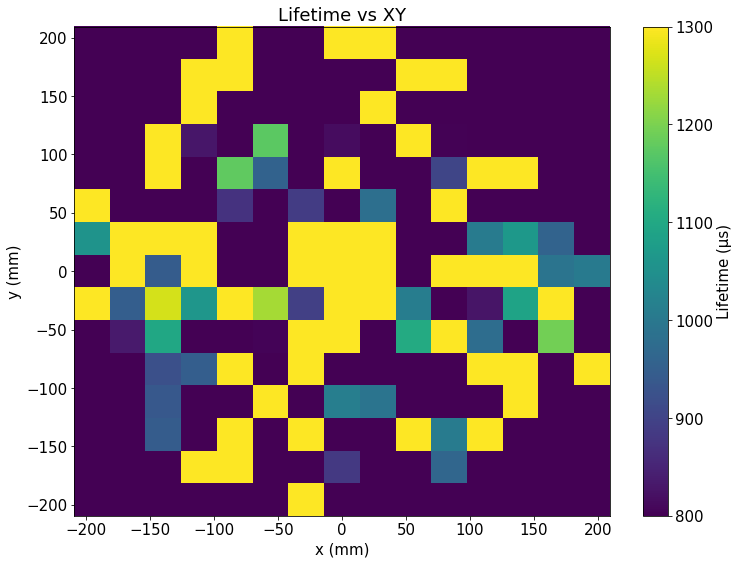

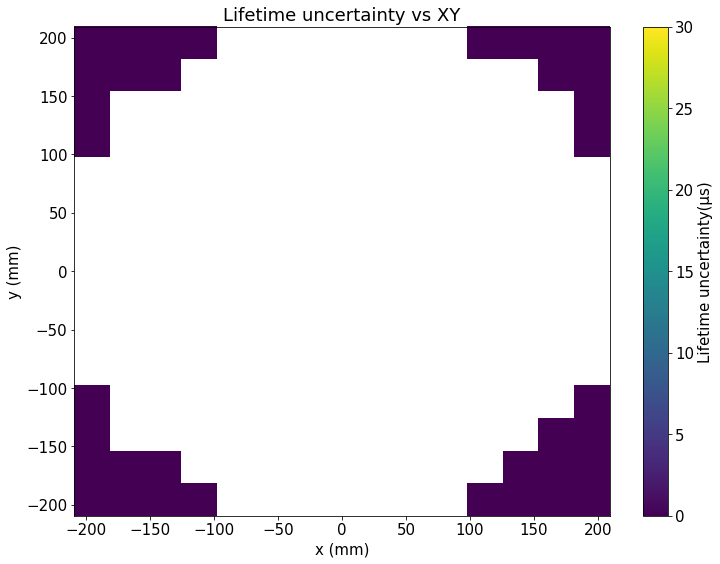

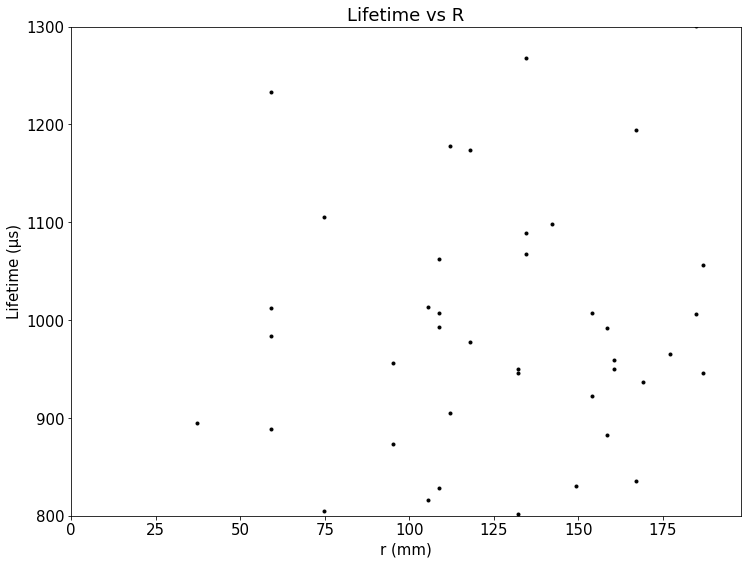

In [58]:
nx, ny = 15, 15
xbins  = np.linspace(*XYrange, nx+1)
ybins  = np.linspace(*XYrange, ny+1)
xybins = xbins, ybins

LT     = np.zeros((nx, ny))
u_LT   = np.zeros((nx, ny))

Z = full.Z  .values
X = full.X  .values
Y = full.Y  .values
E = full.S2e.values

plt.figure(figsize=(nx, ny))

for i in range(nx):
    for j in range(ny):
        sel_r = coref.in_range(E, *Erange_raw)\
              & coref.in_range(X, *xbins[i:i+2])\
              & coref.in_range(Y, *ybins[j:j+2])

        if np.count_nonzero(sel_r) < 100: continue
#        plt.subplot(ny, ny, i*nx+j+1)
#        n, x, y, _ = \
#        hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
        n, x, y = \
        np.histogram2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw))
        x = shift_to_bin_centers(x)
        y = shift_to_bin_centers(y)
#        labels("Drift time (µs)", "S2 energy (pes)",
#               "X {:.0f} - {:.0f} mm; Y {:.0f} - {:.0f} mm".format(*xbins[i:i+2],
#                                                                   *ybins[j:j+2]))
        slice_max = np.argmax(n, axis=1)
        slice_ene = y[slice_max]
        slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]

#        plt.errorbar(x, slice_ene, slice_rms, fmt="*k")

        f_low = fitf.fit(fitf.expo, x, slice_ene-slice_rms, (1e4, -500), fit_range=Zrange_LT)
        f_upp = fitf.fit(fitf.expo, x, slice_ene+slice_rms, (1e4, -500), fit_range=Zrange_LT)

#        plt.plot(x, f_low.fn(x), "r")
#        plt.plot(x, f_upp.fn(x), "r")

        low_cut = f_low.fn(Z)
        upp_cut = f_upp.fn(Z)
        sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

        x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)
#        plt.errorbar(x, y, u_y, fmt="*m")

        seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
        f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

        LT  [i,j] = -f.values[1]
        u_LT[i,j] =  f.errors[1]
#plt.tight_layout()

_, cb = display_matrix(shift_to_bin_centers(xbins),
                       shift_to_bin_centers(ybins),
                       LT, vmin=800, vmax=1300)
cb.set_label("Lifetime (µs)")
labels("x (mm)", "y (mm)", "Lifetime vs XY")
save("LifetimevsXY")

_, cb = display_matrix(shift_to_bin_centers(xbins),
                       shift_to_bin_centers(ybins),
                       u_LT, vmin=0, vmax=30)
cb.set_label("Lifetime uncertainty(µs)")
labels("x (mm)", "y (mm)", "Lifetime uncertainty vs XY")
save("LifetimeUncertaintyvsXY")

plt.figure()
_x = np.repeat(shift_to_bin_centers(xbins), ny)
_y = np.tile  (shift_to_bin_centers(ybins), nx)
_r = (_x**2 + _y**2)**0.5
plt.errorbar(_r, LT.flatten(), u_LT.flatten(), fmt=".k")
plt.xlim(*Rrange)
plt.ylim(800, 1300)
labels("r (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR")

# Correction by attachment

[  7.59763053e+06   8.76674596e+03   7.04280754e+02   1.60527576e+06
   7.08683337e+03   5.86083636e+02   3.33661069e+02   1.52060660e-30]


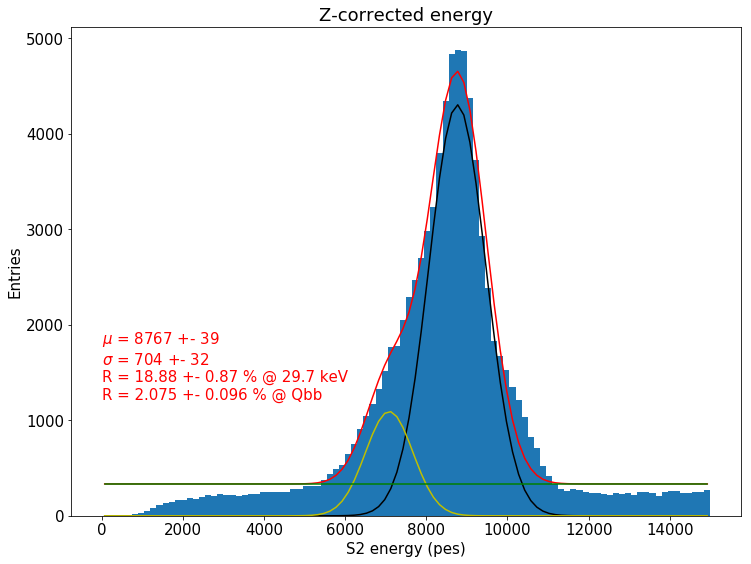

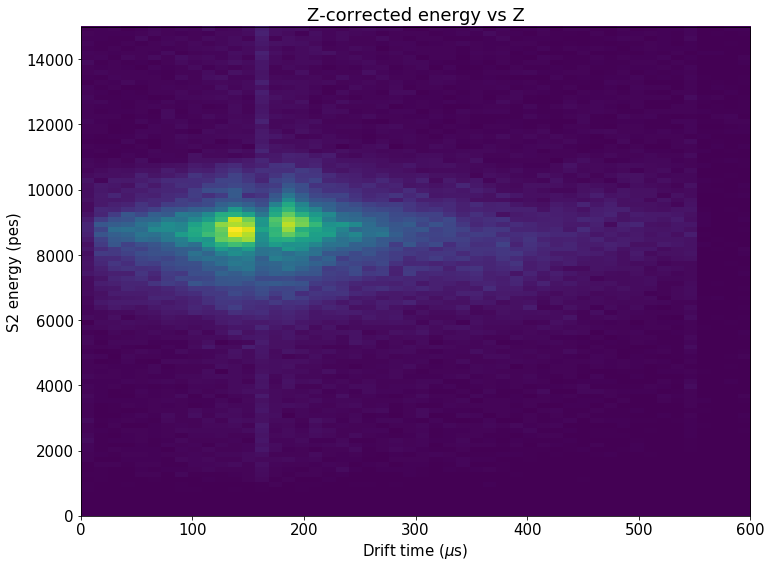

In [59]:
correction = Zcorr(full.Z.values)
E_zcorr    = full.S2e.values * correction.value

y, x, _ = hist(E_zcorr, 100, range=Erange_zcorr)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3,  9000, 400, 1e3,  7000, 400,  100, 1e-3
low  = 1e1,  8000, 200, 1e1,  6000, 200,    0, 0
upp  = 1e8, 10000, 900, 1e8,  8000, 900, 1000, 1e+1
f    = fitf.fit(fun, x, y, seed, fit_range=(5000, 14000), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_zcorr[0], max(y)/4, gausstext(f.values, f.errors, 29.7), color=fitOpt)

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("EcorrZ")

hist2d(full.Z.values, E_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("EcorrZvsZ")

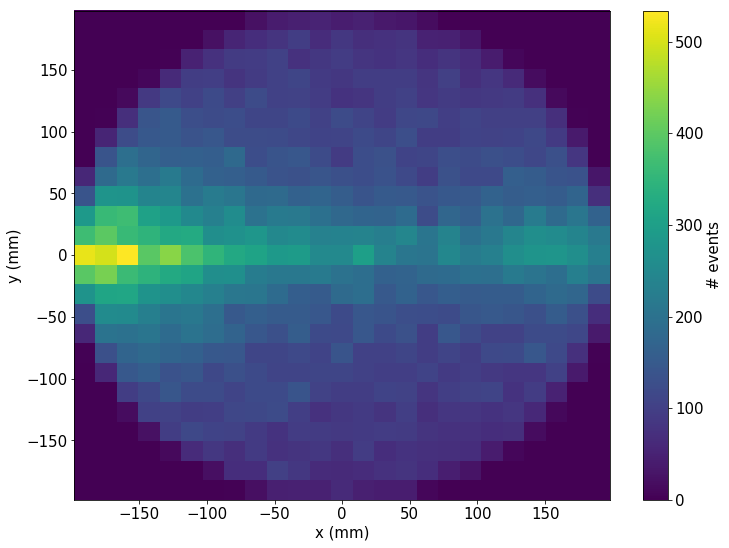

In [60]:
sel = coref.in_range(E_zcorr, 6e3, 11e3)
data = full[sel]
hist2d(data.X, data.Y, (nX//2, nY//2), (XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

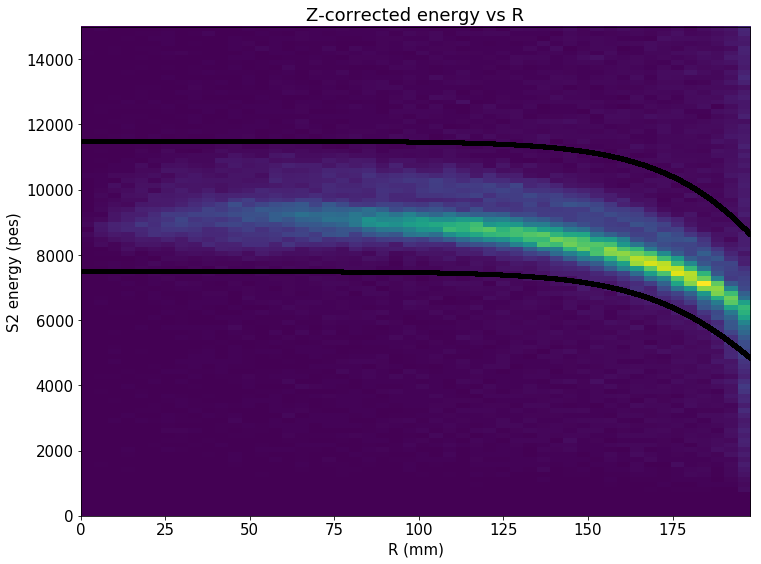

In [61]:
low_cut   =  7500 *(1/(1 + np.exp((full.R.values-210)/20)))
high_cut  = 11500 *(1/(1 + np.exp((full.R.values-220)/20)))

hist2d(full.R.values, E_zcorr, (50, 100), range=(Rrange, Erange_zcorr))
plt.plot(full.R.values,  low_cut, ".k")
plt.plot(full.R.values, high_cut, ".k")
labels("R (mm)", "S2 energy (pes)", "Z-corrected energy vs R")
save("EcorrZvsR")

# Tracking

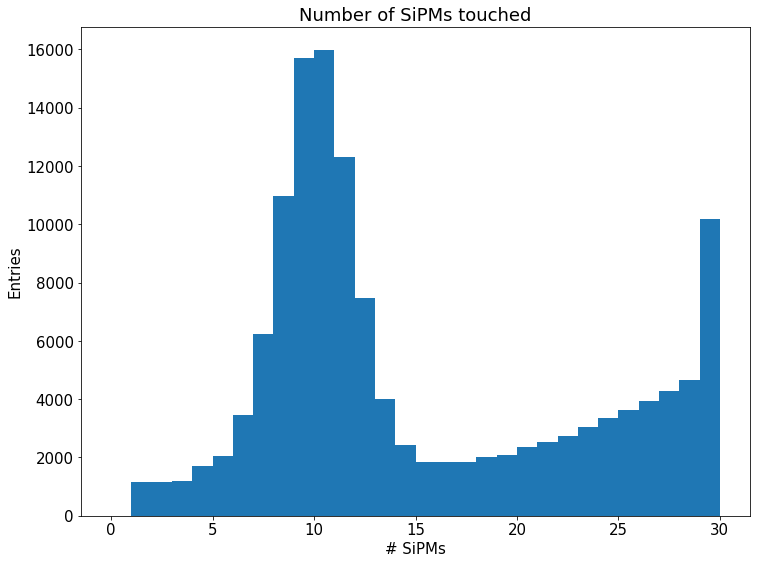

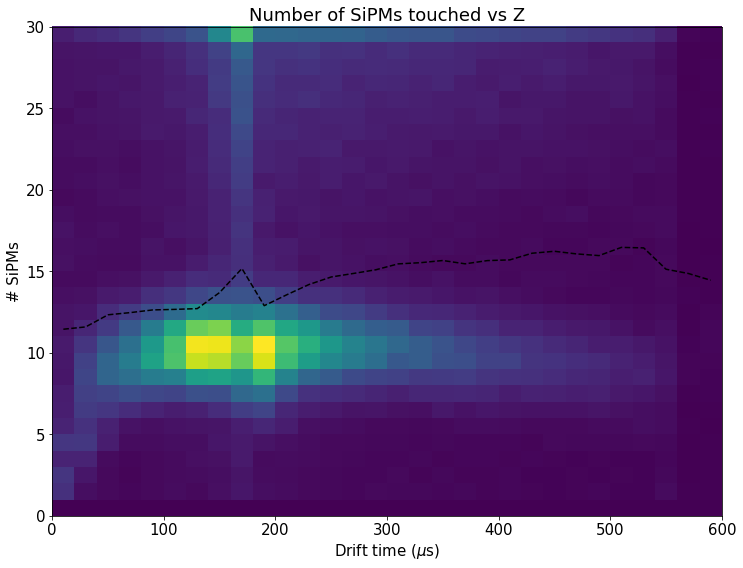

In [62]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# XR distribution

In [63]:
sel     = coref.in_range(E_zcorr, low_cut, high_cut)
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

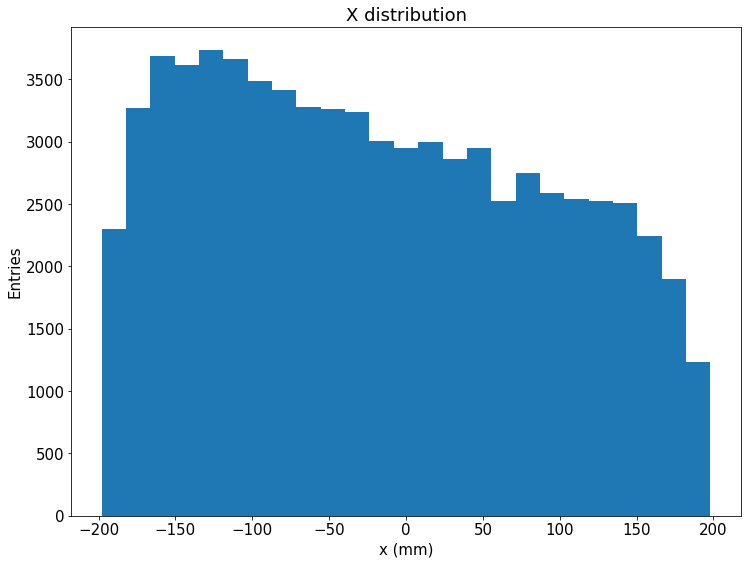

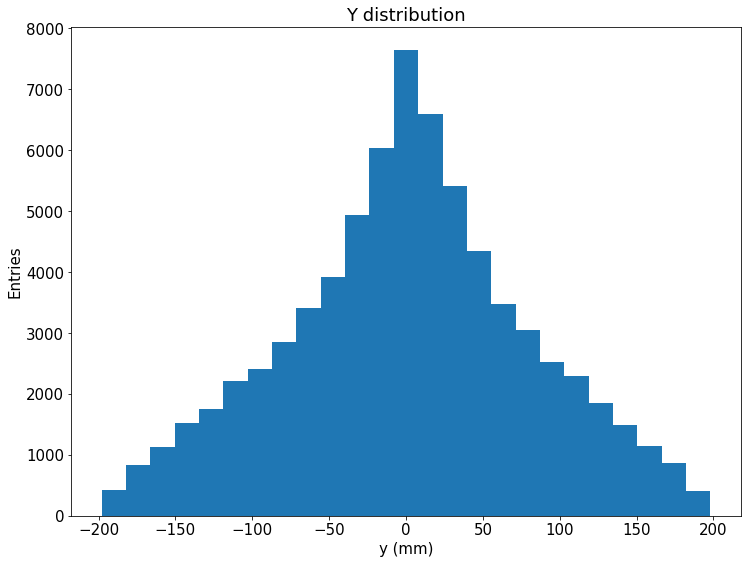

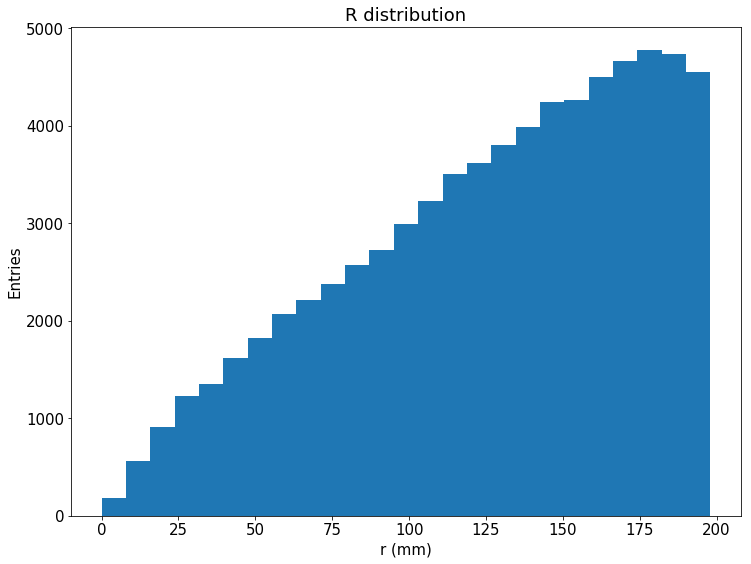

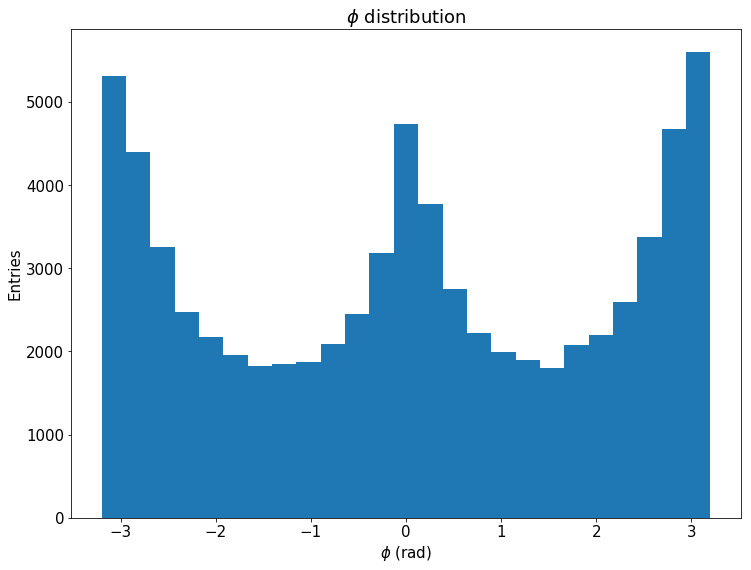

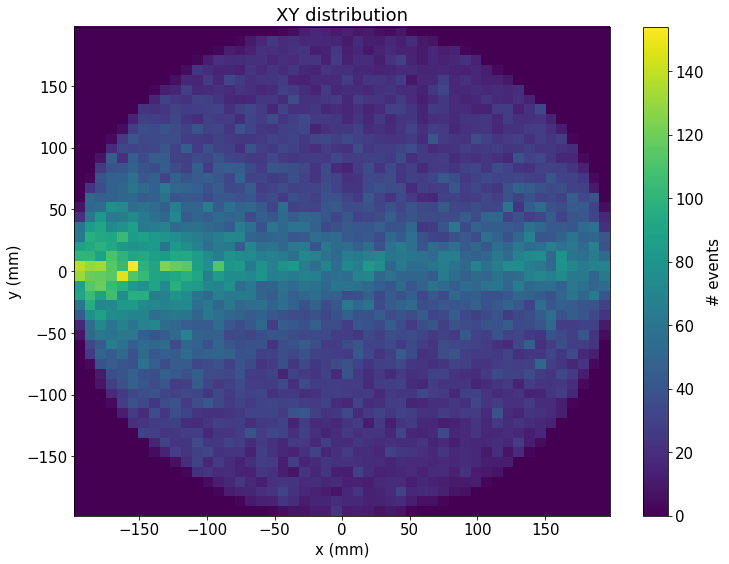

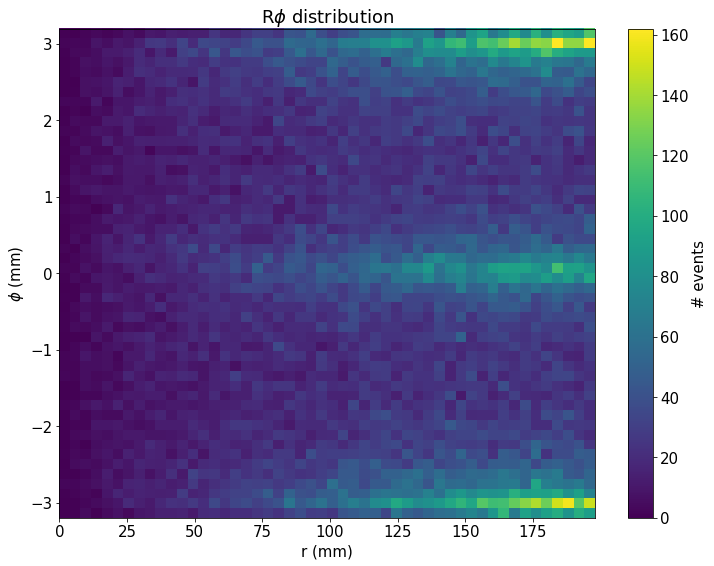

In [64]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

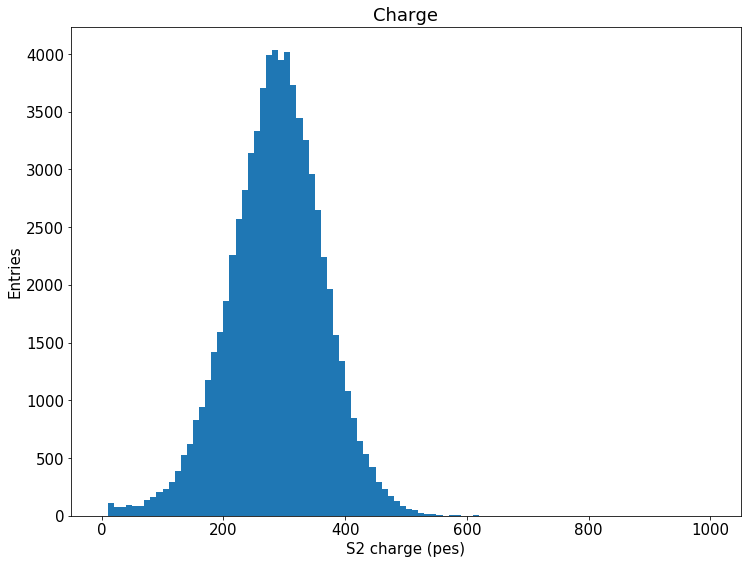

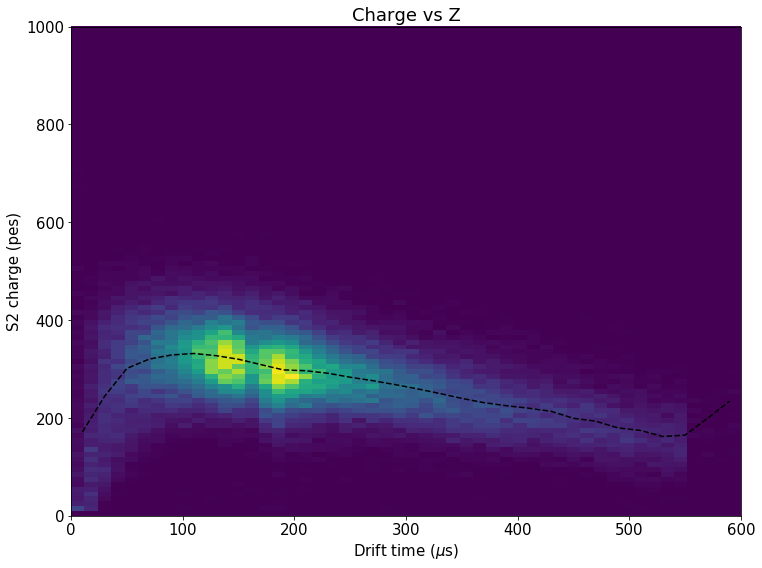

In [65]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

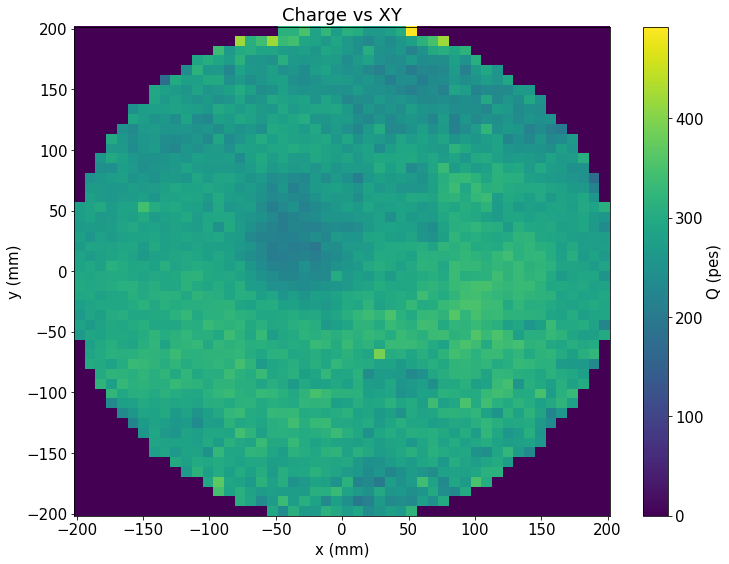

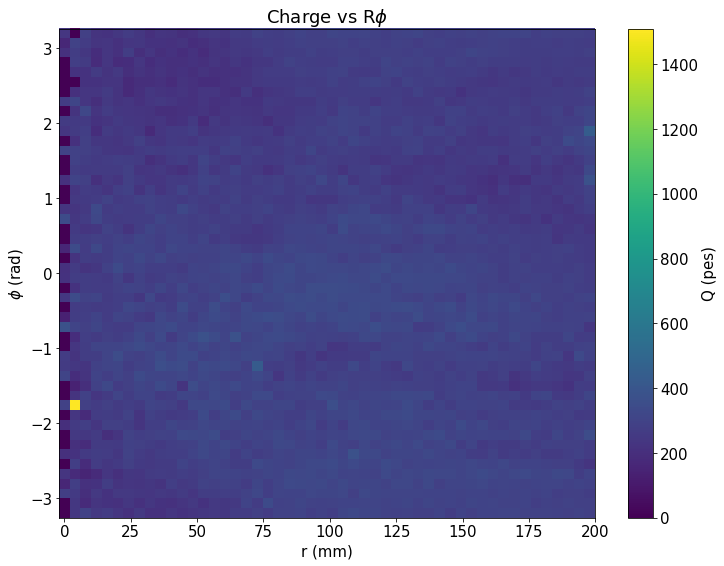

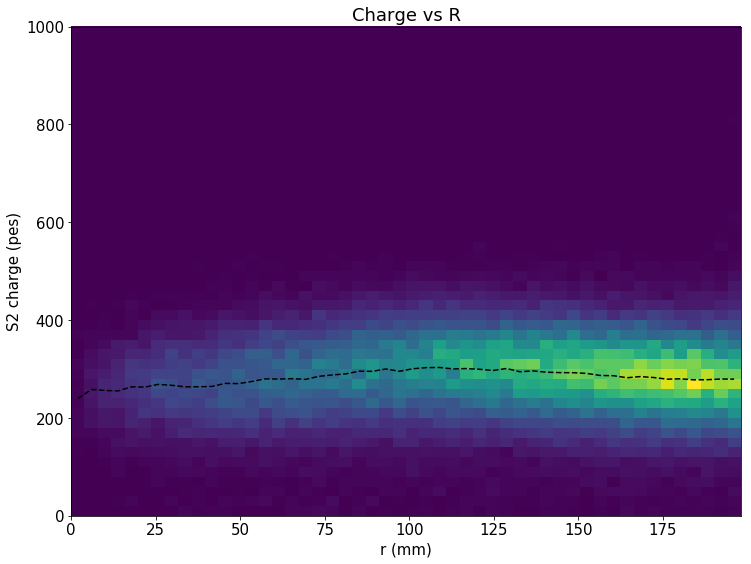

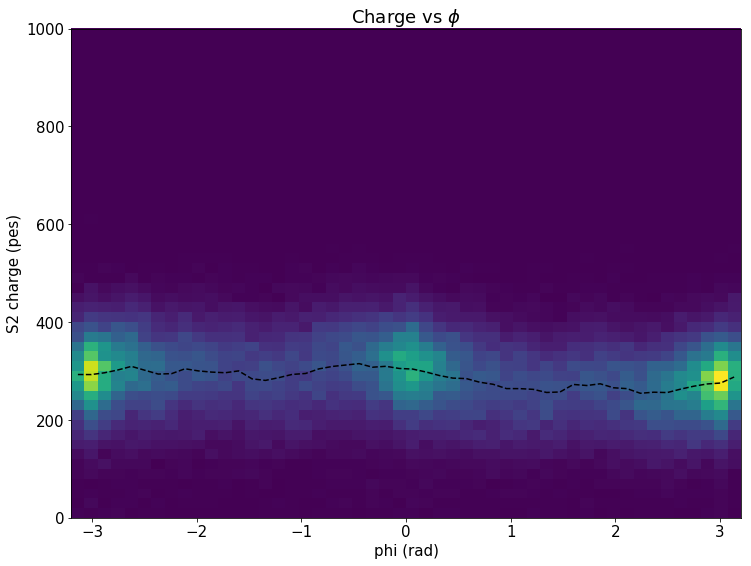

In [66]:
x, y, Q, u_Q = \
fitf.profileXY(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

x, y, q, u_q = \
fitf.profileXY(Kr.R, Kr.Phi, Kr.S2q, nX, nY, Rrange, Prange)
_, cb = display_matrix(x, y, q)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

Reference energy = 9139.681920990515 pes


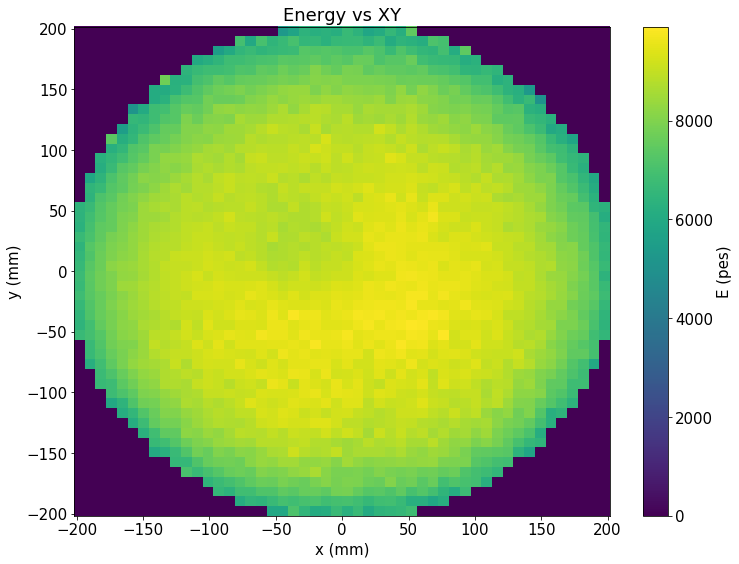

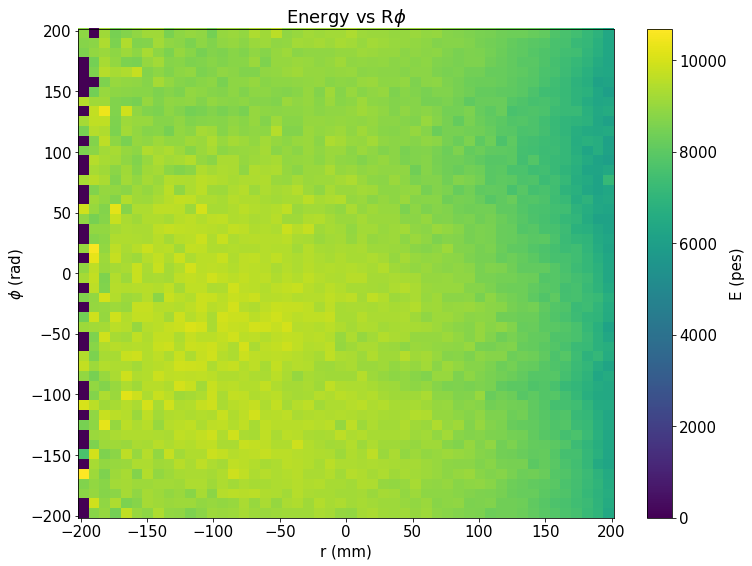

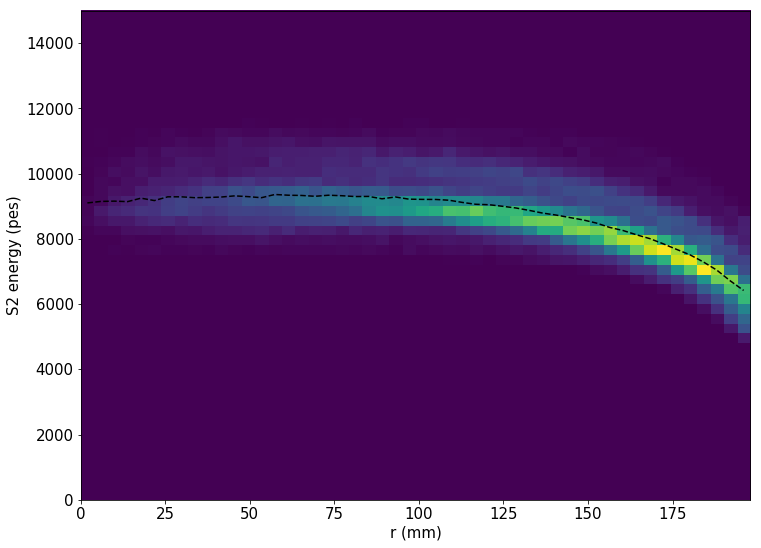

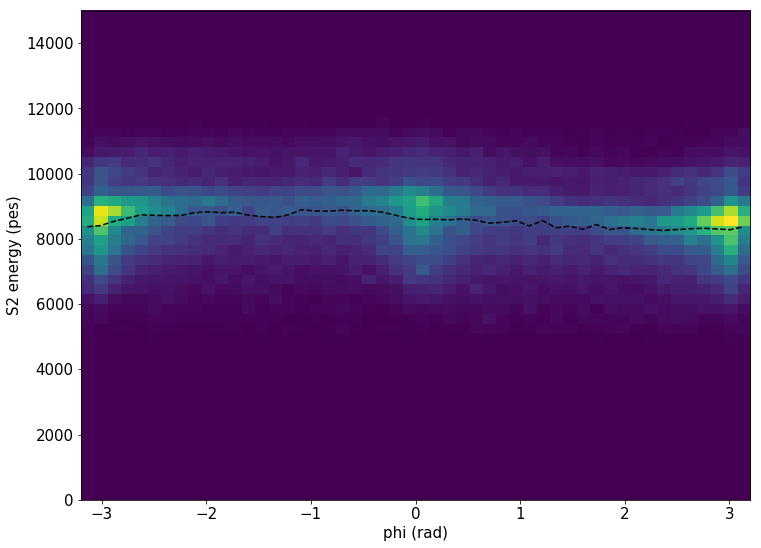

In [67]:
sel = sel_Kr = coref.in_range(Kr.Z.values, *Zrange_XY)

xc, yc, Ec, u_Ec = \
fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nX, nY, XYrange, XYrange)
_, cb = display_matrix(xc, yc, Ec)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

rc, pc, ec, u_ec = \
fitf.profileXY(Kr.R.values[sel], Kr.Phi.values[sel], E_zcorr[sel], nX, nY, Rrange, Prange)
_, cb = display_matrix(xc, yc, ec)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EvsRPhi")

hist2d(Kr.R.values[sel], E_zcorr[sel], (50, 50), range=(Rrange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.R.values[sel], E_zcorr[sel], 50, xrange=Rrange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(Kr.Phi.values[sel], E_zcorr[sel], (50, 50), range=(Prange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.Phi.values[sel], E_zcorr[sel], 50, xrange=Prange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

XYcorr2    = corrf.Correction((xc, yc), Ec, u_Ec, "index", index=(nX//2, nY//2))
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorr2._fs==1)[0])]))

# Correction maps

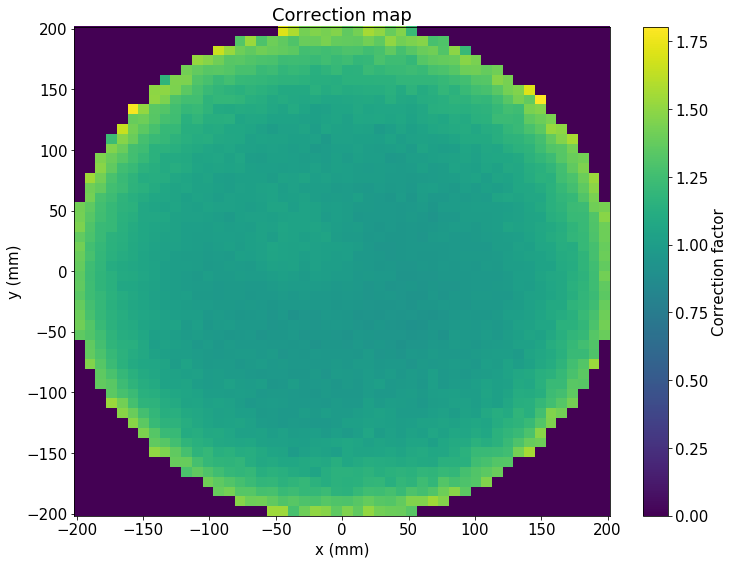

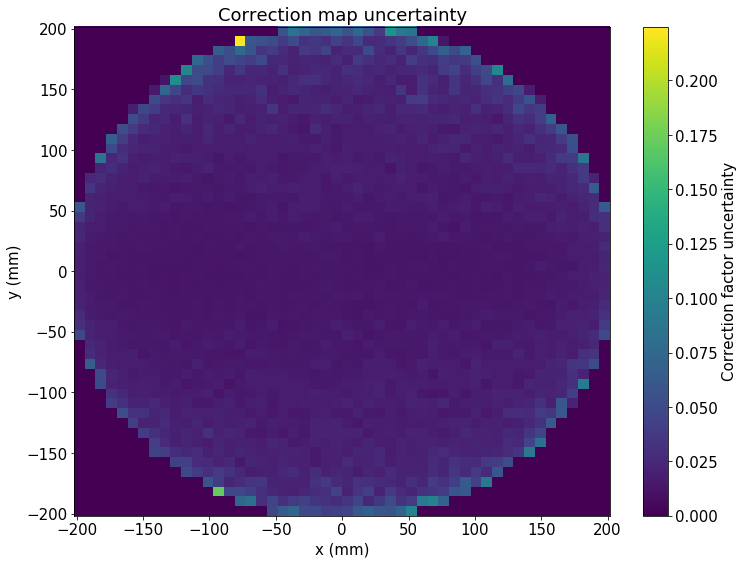

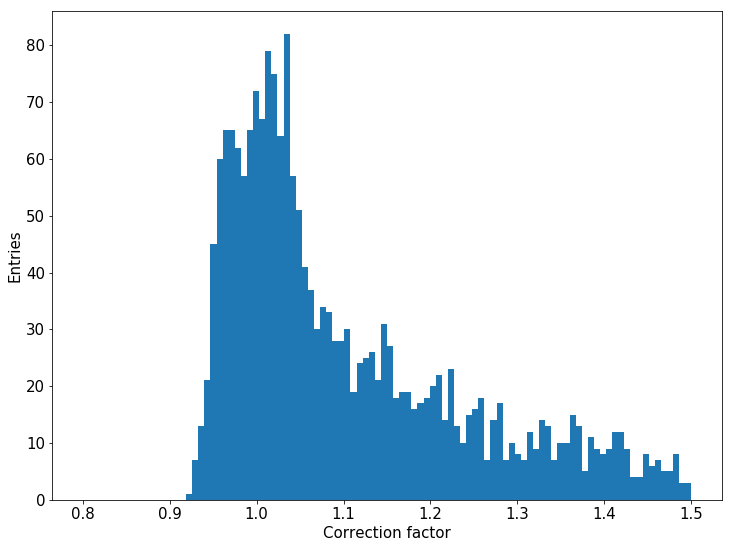

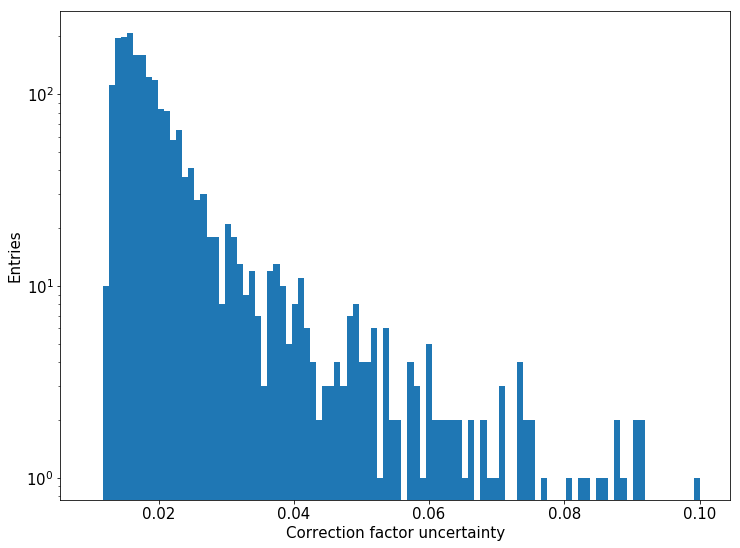

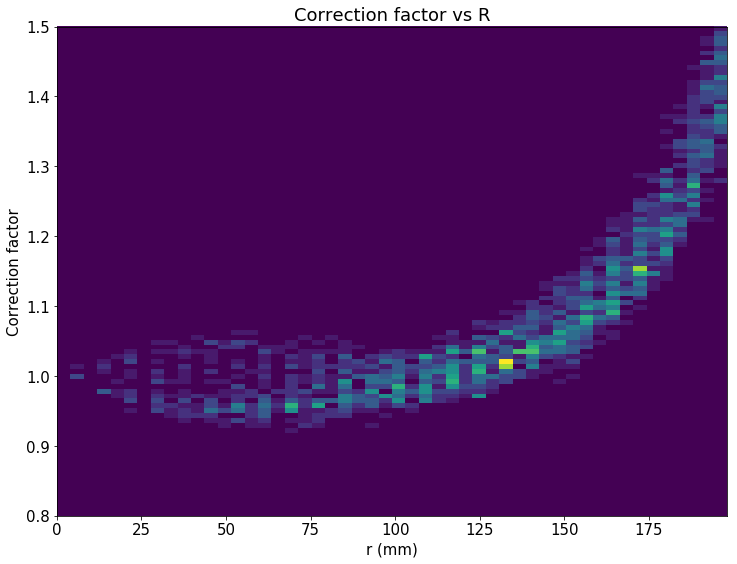

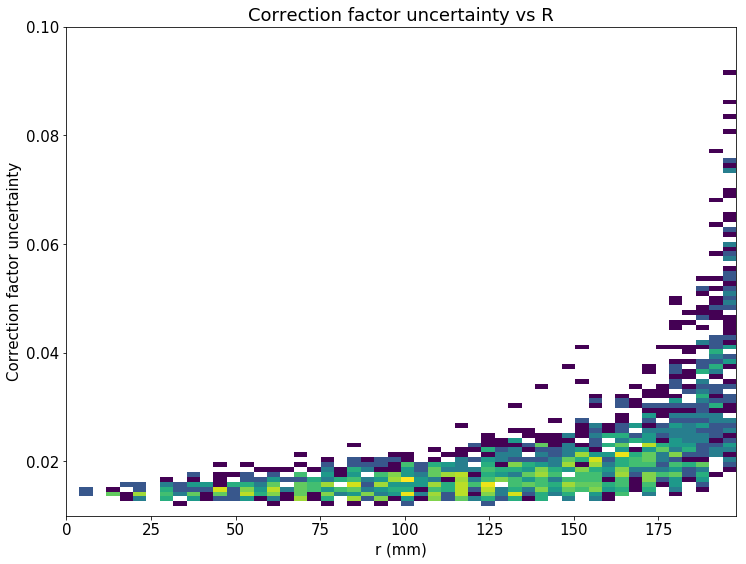

In [68]:
_r = (np.repeat(xc, yc.size)**2 +
      np.tile  (yc, xc.size)**2)**0.5
_f = XYcorr2._fs.flatten()
_u = XYcorr2._us.flatten()

_, cb = display_matrix(xc, yc, _f)
labels("x (mm)", "y (mm)", "Correction map")
cb.set_label("Correction factor")
save("CorrectionMap")

_, cb = display_matrix(xc, yc, _u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
cb.set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

hist(_f, 100, Frange)
labels("Correction factor", "Entries")
save("CorrectionMapHist")

hist(_u[_u > 0], 100, Urange)
plt.yscale("log")
labels("Correction factor uncertainty", "Entries")
save("CorrectionMapUncertaintyHist")

hist2d(_r, _f, (nR, 100), (Rrange, Frange))
labels("r (mm)", "Correction factor", "Correction factor vs R")
save("CorrectionFactorVsR")

hist2d(_r, _u, (nR, 100), (Rrange, Urange), norm=LogNorm())
labels("r (mm)", "Correction factor uncertainty", "Correction factor uncertainty vs R")
save("CorrectionFactorUncertaintyVsR")

[ 9.56414315  0.99969545  0.01423692]
[ 0.12189108  0.00020951  0.00020951]


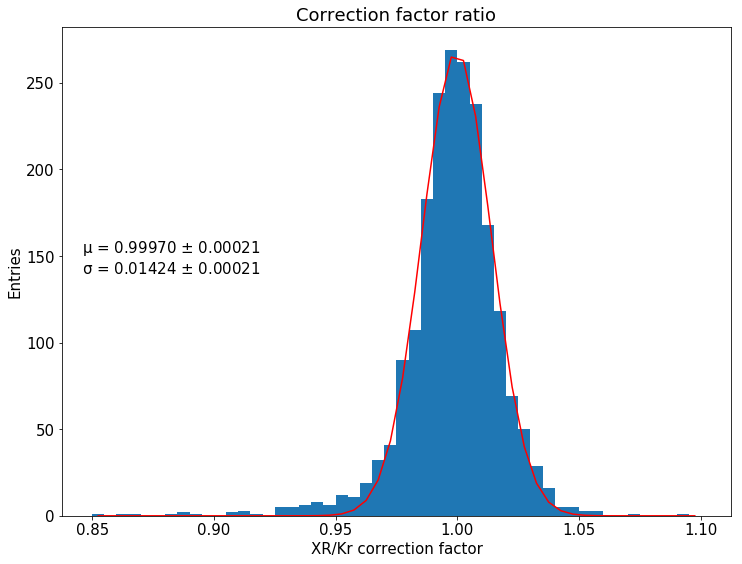

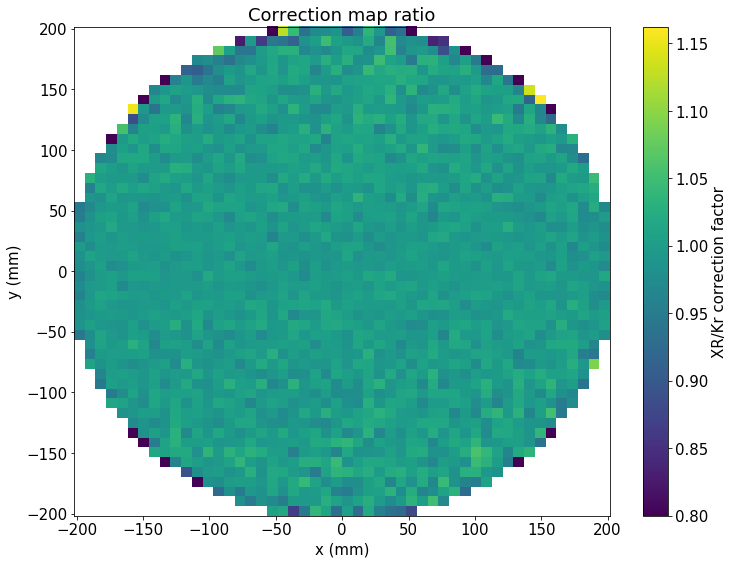

In [69]:
ratio = XYcorr2._fs / XYcorr._fs

y, x, _ = \
hist(ratio.flatten(), 50, (0.85, 1.1))
labels("XR/Kr correction factor", "Entries", "Correction factor ratio")

f = fitf.fit(fitf.gauss, x, y, (1e3, 1, 0.1))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
print(f.errors)
plt.text(plt.xlim()[0] * 1.01, plt.ylim()[1]/2,
"""µ = {:.5f} $\pm$ {:.5f}
σ = {:.5f} $\pm$ {:.5f}""".format(f.values[1], f.errors[1],
                                                          f.values[2], f.errors[2]))
_, cb = display_matrix(xc, yc, ratio, vmin=0.8)
labels("x (mm)", "y (mm)", "Correction map ratio")
cb.set_label("XR/Kr correction factor")
save("CorrectionMapRatio")

[  3.96912578e+02  -3.35023369e-02   8.45655018e-01]
[ 9.58975249  0.02054558  0.01558457]


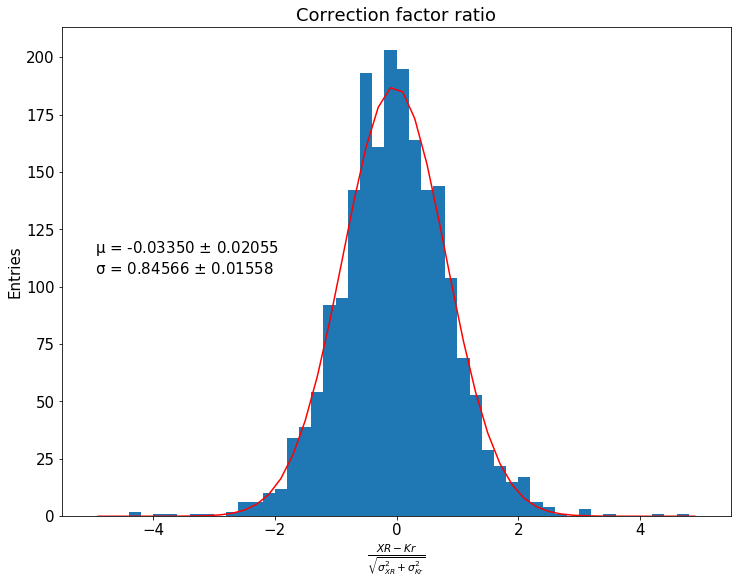

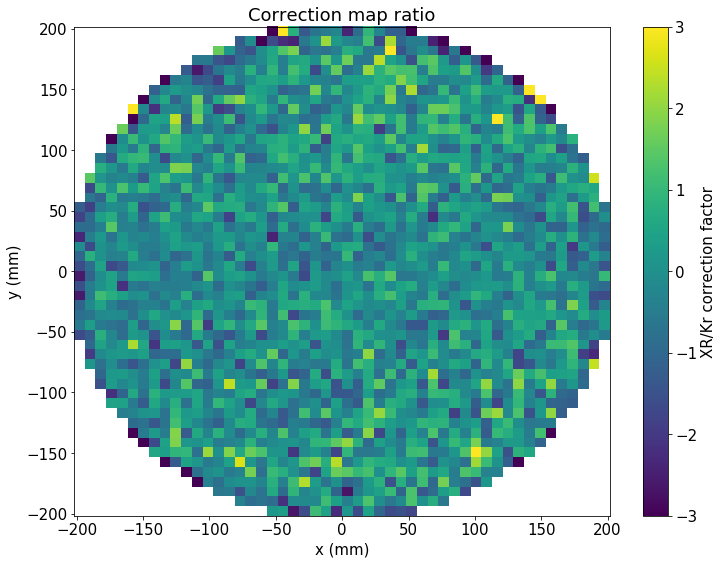

In [70]:
ratio = (XYcorr2._fs - XYcorr._fs)/(XYcorr2._us**2 + XYcorr._us**2)**0.5

y, x, _ = \
hist(ratio.flatten(), 50, (-5, 5))
labels(r"$\frac{XR - Kr}{\sqrt{\sigma_{XR}^2 + \sigma_{Kr}^2}}$", "Entries", "Correction factor ratio")

f = fitf.fit(fitf.gauss, x, y, (1e3, 1, 1), fit_range=(-3, 3), sigma=poisson_uncertainty(y))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
print(f.errors)
plt.text(plt.xlim()[0] * 0.9, plt.ylim()[1]/2,
"""µ = {:.5f} $\pm$ {:.5f}
σ = {:.5f} $\pm$ {:.5f}""".format(f.values[1], f.errors[1],
                                  f.values[2], f.errors[2]))
_, cb = display_matrix(xc, yc, ratio, vmin=-3, vmax=3)
labels("x (mm)", "y (mm)", "Correction map ratio")
cb.set_label("XR/Kr correction factor")
save("CorrectionMapRatioChi2")

# Charge/Energy ratio

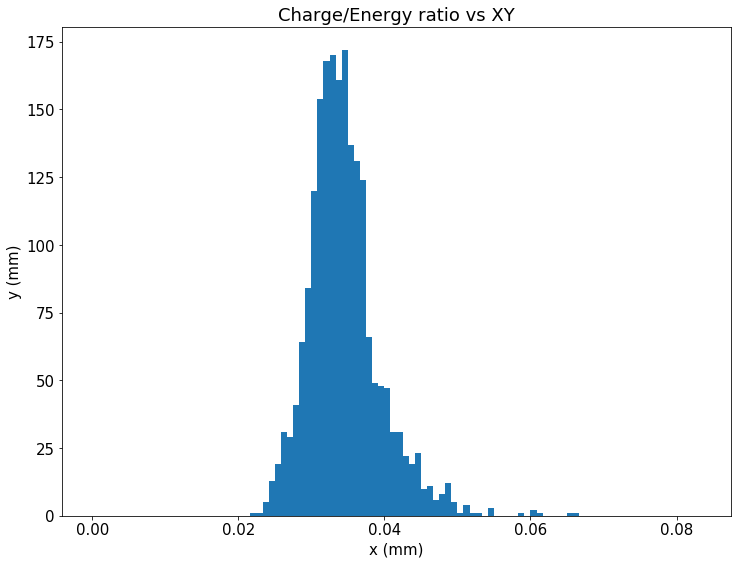

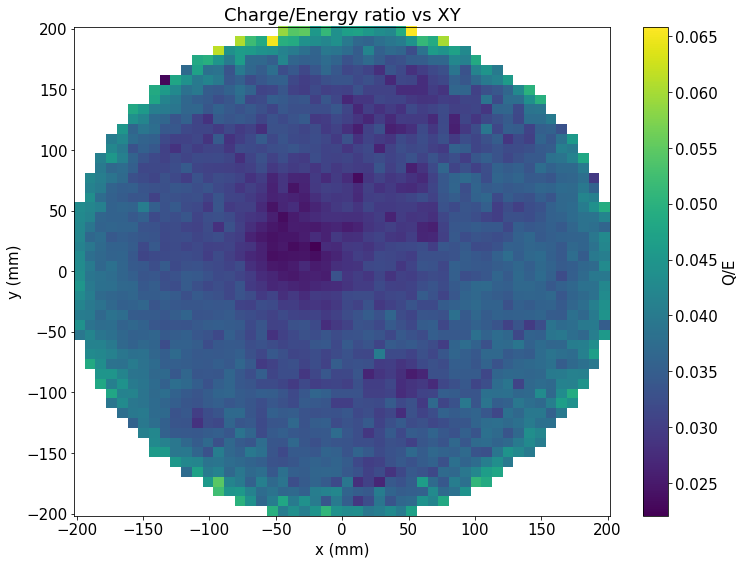

In [71]:
ratio = Q/Ec

hist(ratio.flatten(), 100, QErange)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

_, cb = display_matrix(xc, yc, ratio)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

# Correction by position with Kr map

[  3.05857442e+06   8.86118803e+03   2.65770259e+02   4.95188201e+05
   1.00903619e+04   2.35969492e+02  -1.39767006e+04   3.14451419e+00
  -1.68457537e-04]


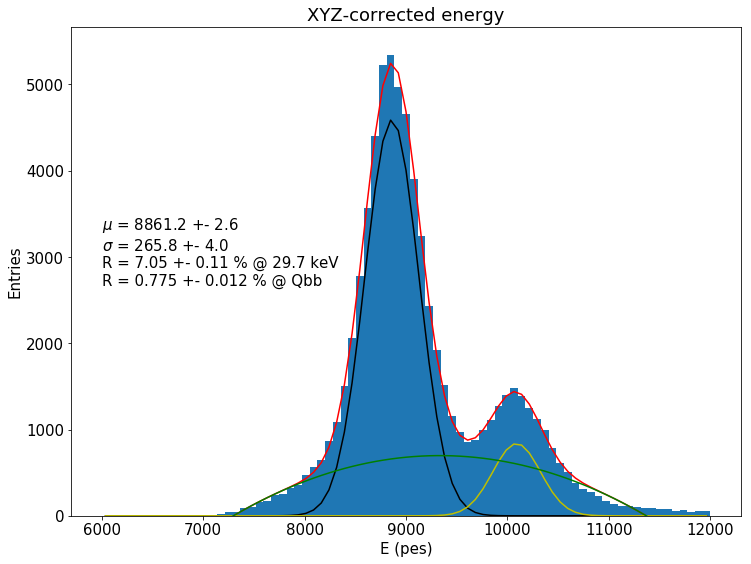

In [72]:
E_xyzcorr = E_zcorr * XYcorr(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr, bins)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 9000, 400, 1e3, 10000, 400,  100
low  = 1e1, 8000, 200, 1e1,  9900, 200,    0
upp  = 1e8, 9500, 900, 1e8, 11000, 900, 5000

seed = 1e3, 9000, 400, 1e3, 10000, 400, -1e5, 1e1, -1e-3
low  = 1e1, 8000, 200, 1e1,  9900, 200, -1e7,    0, -1e-1
upp  = 1e8, 9500, 900, 1e8, 11000, 900,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 11500), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 29.7))

plt.ylim(0)
labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

# Correction by position with XR map

[  3.29999232e+06   8.86118042e+03   2.91567744e+02   6.74560865e+05
   1.00418871e+04   2.88802042e+02  -8.65812084e+03   1.98015656e+00
  -1.06865046e-04]


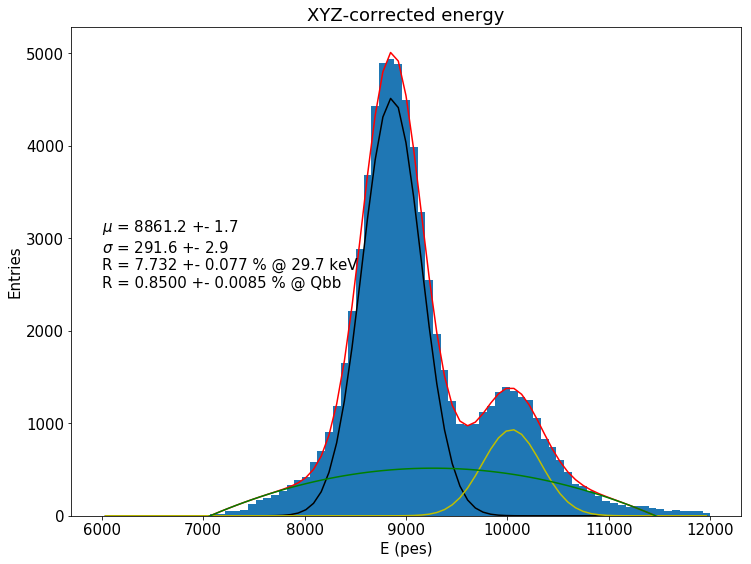

In [73]:
E_xyzcorr2 = E_zcorr * XYcorr2(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr2, bins)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 9000, 400, 1e3, 10000, 400,  100
low  = 1e1, 8000, 200, 1e1,  9900, 200,    0
upp  = 1e8, 9500, 900, 1e8, 11000, 900, 5000

seed = 1e3, 9000, 400, 1e3, 10000, 400, -1e5, 1e1, -1e-3
low  = 1e1, 8000, 200, 1e1,  9900, 200, -1e7,    0, -1e-1
upp  = 1e8, 9500, 900, 1e8, 11000, 900,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 11500), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 29.7))

plt.ylim(0)
labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

# Correction by time

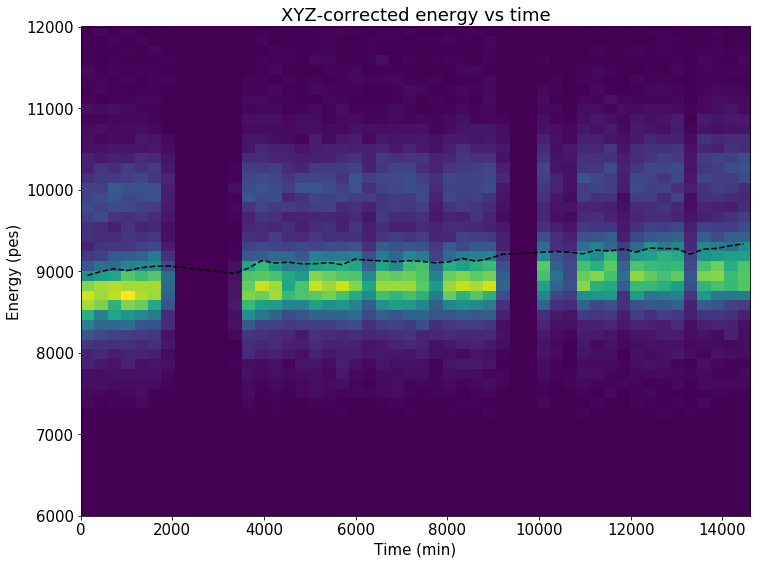

In [74]:
T      = (Kr.time.values - np.min(Kr.time.values))/60
Trange = 0, np.max(T)

hist2d(T, E_xyzcorr, (50, 50), range=(Trange, Erange_xycorr))

x, y, u_y = fitf.profileX(T, E_xyzcorr, 50, Trange, Erange_xycorr)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

Tcorr = corrf.Correction((x,), y, u_y, "max")

[  3.04026086e+06   9.04491500e+03   2.55439740e+02   4.97242296e+05
   1.03103584e+04   2.23279522e+02  -1.55064249e+04   3.41871177e+00
  -1.80178395e-04]


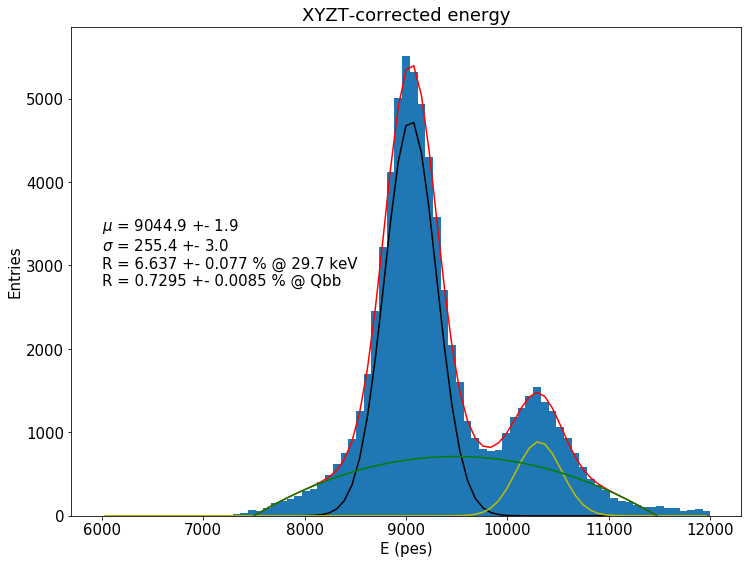

In [75]:
E_xyztcorr = E_xyzcorr * Tcorr(T).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr, bins)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
#seed = 1e3, 9000, 400, 1e3, 10000, 400,  100
#low  = 1e1, 8000, 200, 1e1,  9900, 200,    0
#upp  = 1e8, 9500, 900, 1e8, 11000, 900, 5000

seed = 1e3, 9000, 400, 1e3, 10000, 400, -1e5, 1e1, -1e-3
low  = 1e1, 8000, 200, 1e1,  9900, 200, -1e7,    0, -1e-1
upp  = 1e8, 9500, 900, 1e8, 11000, 900,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 11500), bounds=(low, upp))
print(f.values)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 29.7))

plt.ylim(0)
labels("E (pes)", "Entries", "XYZT-corrected energy")
save("EcorrZXYT")

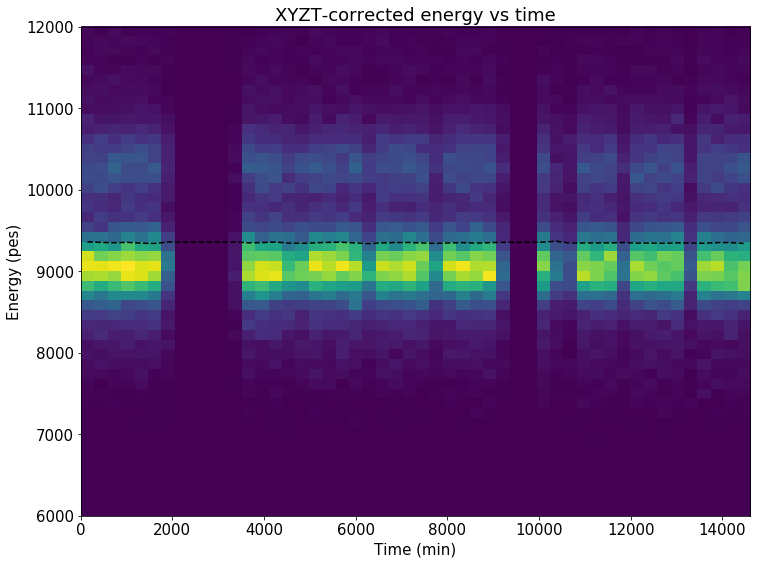

In [76]:
hist2d(T, E_xyztcorr, (50, 50), range=(Trange, Erange_xycorr))
x, y, _ = fitf.profileX(T, E_xyztcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZT-corrected energy vs time")
save("EcorrZXYTvsT")

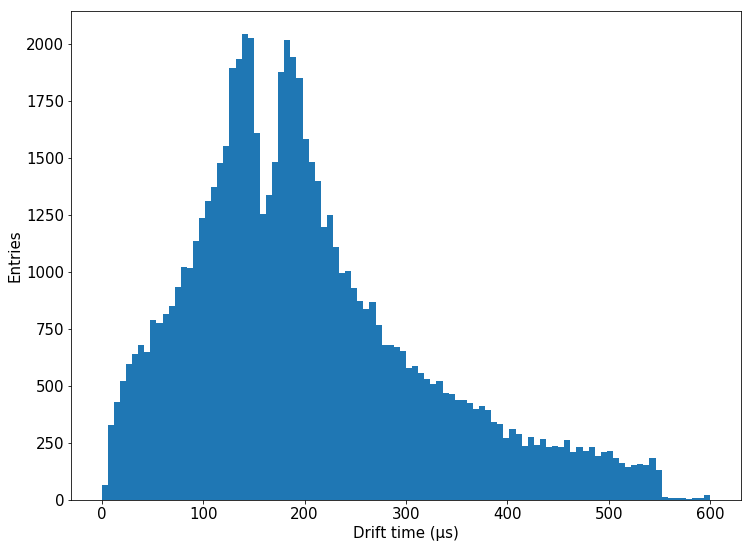

In [126]:
XRsel = coref.in_range(E_xyztcorr, 8e3, 11e3)

hist(full.Z.values[XRsel], 100, (0, 600))
labels("Drift time (µs)", "Entries")

In [77]:
Narange_zcorr   = 100e3, 200e3
Narange_xyzcorr = 120e3, 170e3
Zrange_Na       = 100, 200
Yrange_Na       = -30,  30
E_zcorr_full    = full.S2e.values * correction.value

In [78]:
full.R.values.size, E_zcorr_full.size, Rrange, Narange_zcorr

(444610, 444610, (0, 198), (100000.0, 200000.0))

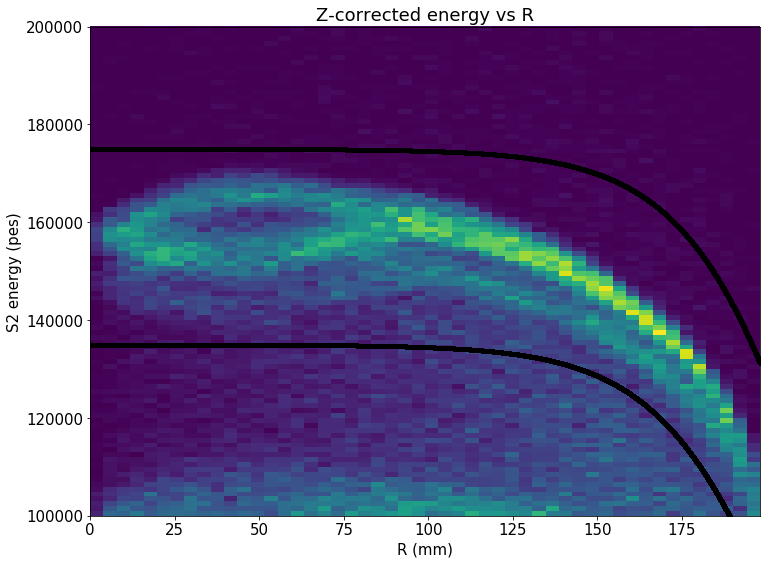

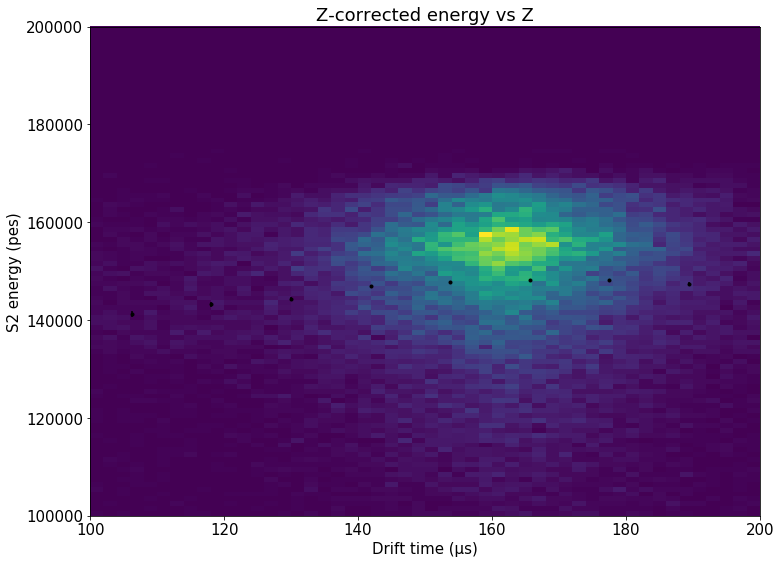

In [79]:
low_cut   = 135e3 *(1/(1 + np.exp((full.R.values-210)/20)))
high_cut  = 175e3 *(1/(1 + np.exp((full.R.values-220)/20)))

hist2d(full.R.values, E_zcorr_full , (50, 100), range=(Rrange, Narange_zcorr))
plt.plot(full.R.values,  low_cut, ".k")
plt.plot(full.R.values, high_cut, ".k")
labels("R (mm)", "S2 energy (pes)", "Z-corrected energy vs R")
sel_r = coref.in_range(E_zcorr_full, low_cut, high_cut)

hist2d(full.Z.values[sel_r], E_zcorr_full[sel_r] , (50, 100), range=(Zrange_Na, Narange_zcorr))
x, y, u_y = fitf.profileX(full.Z.values[sel_r], E_zcorr_full[sel_r], 50)
plt.errorbar(x, y, u_y, fmt="k.")
labels("Drift time (µs)", "S2 energy (pes)", "Z-corrected energy vs Z")

In [80]:
sel_y = coref.in_range(full.Y.values, *Yrange_Na)

In [81]:
Na      =         full[sel_r & sel_y]
E_zcorr = E_zcorr_full[sel_r & sel_y]

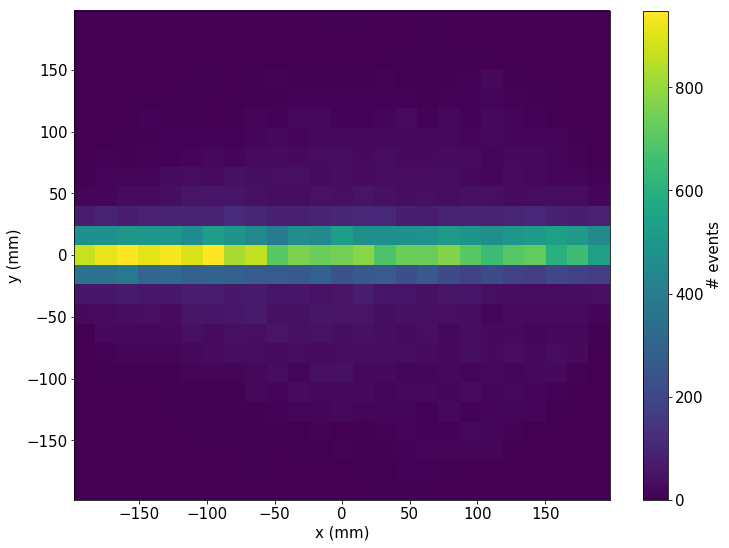

In [82]:
data = full[sel_r]
hist2d(data.X, data.Y, (nX//2, nY//2), (XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

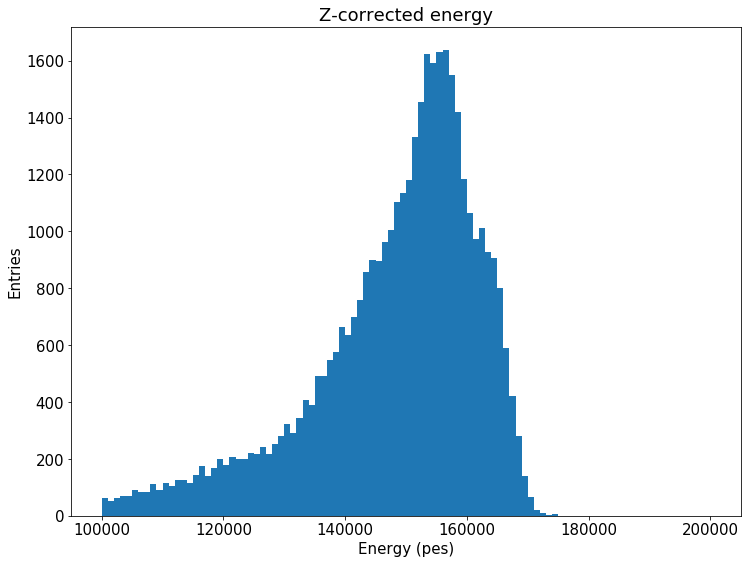

In [83]:
hist(E_zcorr, 100, Narange_zcorr)
labels("Energy (pes)", "Entries", "Z-corrected energy")

# Apply Kr map

14.4104123713
[  1.10338538e+07   1.60629886e+05   1.57639985e+03   4.33722455e+06
   1.51151164e+05   1.68270047e+03  -1.16194914e+04   1.56757367e-01
  -5.20906745e-07]
[  3.77555800e-01   3.07767560e+01   2.58386585e+01   1.73964292e+00
   6.04756007e+01   5.48024726e+01   7.40543251e+02   9.93722940e-03
   3.30441981e-08]
(Measurement(value=2.3062580373013781, uncertainty=0.037804295049042841), Measurement(value=1.0515438986098378, uncertainty=0.017236959246148854))
(Measurement(value=2.6161532650998609, uncertainty=0.040175797584748103), Measurement(value=1.1576577265658057, uncertainty=0.017777942567578187))


(0, 3165.0881028395884)

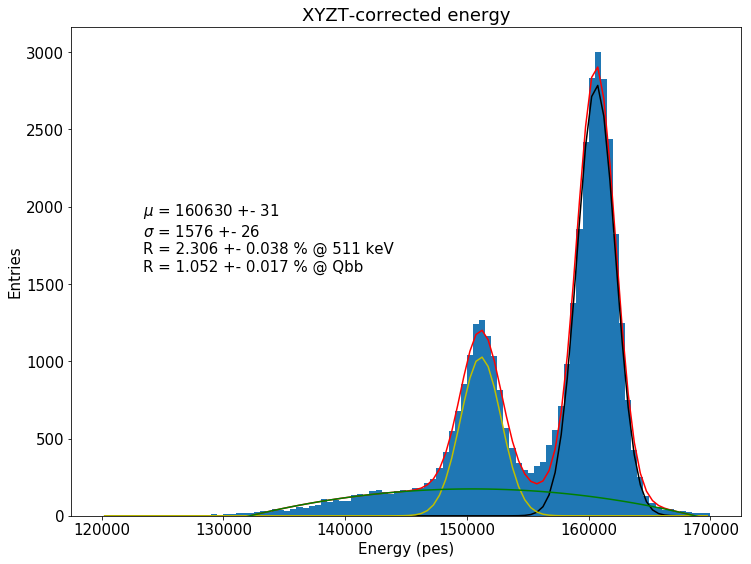

In [84]:
T      = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr = E_zcorr * XYcorr(Na.X.values, Na.Y.values).value * Tcorr(T).value
y, x, _ = \
hist(E_xyzcorr, 100, Narange_xyzcorr)
labels("Energy (pes)", "Entries", "XYZT-corrected energy")

fit_range = 132e3, 168e3
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2, +1e-8

seed = 1e5, 160e3, 1500, 1e5, 150e3, 1500, -1e5, 1e1, -1e-3
low  = 1e1, 155e3, 1000, 1e1, 145e3, 1000, -1e7,    0, -1e-1
upp  = 1e9, 165e3, 3000, 1e8, 155e3, 3000,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=fit_range, sigma=poisson_uncertainty(y), bounds=(low, upp))
assert not np.any(np.isclose(f.values, seed))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0]*1.05, plt.ylim()[1]/2, gausstext(f.values, f.errors, 511))
print(f.chi2)
print(f.values)
print(f.errors)
print(resolution(f.values[:3], f.errors, 511))
print(resolution(f.values[3:], f.errors, 511 - 29.7))
plt.ylim(0)

# Apply XR map

2.58394024587
[  1.10403770e+07   1.60211857e+05   2.07215489e+03   4.54237168e+06
   1.50840306e+05   2.19998506e+03  -1.11557267e+04   1.50967432e-01
  -5.03100702e-07]
[  3.16899473e-01   2.63098217e+01   2.29501243e+01   1.32738802e+00
   5.14584014e+01   4.69922814e+01   4.74030904e+02   6.36258221e-03
   2.11603853e-08]
(Measurement(value=3.0394529334269222, uncertainty=0.033667121192369184), Measurement(value=1.3858458748166478, uncertainty=0.01535060487638203))
(Measurement(value=3.4274425898555374, uncertainty=0.035759891785954477), Measurement(value=1.516656324932677, uncertainty=0.015823887529611957))


(0, 2392.0880296316923)

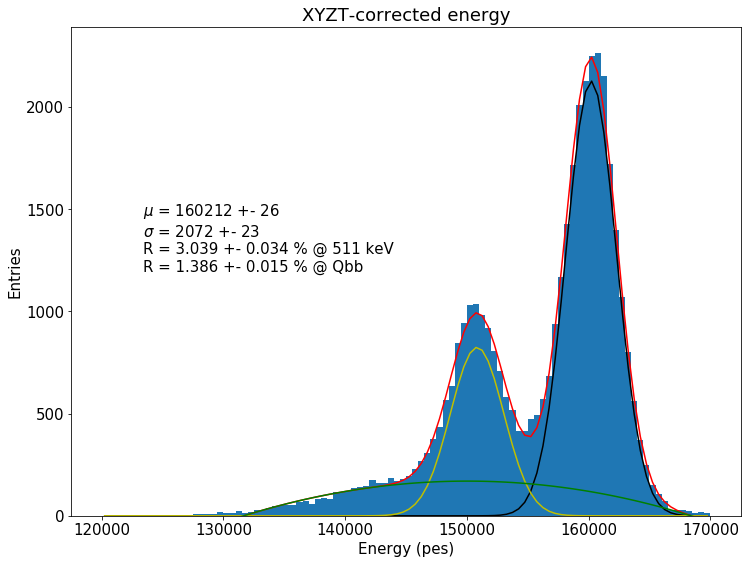

In [85]:
T      = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr = E_zcorr * XYcorr2(Na.X.values, Na.Y.values).value * Tcorr(T).value
y, x, _ = \
hist(E_xyzcorr, 100, Narange_xyzcorr)
labels("Energy (pes)", "Entries", "XYZT-corrected energy")

fit_range = 132e3, 168e3
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2, +1e-8

seed = 1e5, 160e3, 1500, 1e5, 150e3, 1500, -1e5, 1e-1, -1e-3
low  = 1e1, 155e3, 1000, 1e1, 145e3, 1000, -1e7,    0, -1e-1
upp  = 1e9, 165e3, 3000, 1e8, 155e3, 3000,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=fit_range, sigma=poisson_uncertainty(y), bounds=(low, upp))
assert not np.any(np.isclose(f.values, seed))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0]*1.05, plt.ylim()[1]/2, gausstext(f.values, f.errors, 511))
print(f.chi2)
print(f.values)
print(f.errors)
print(resolution(f.values[:3], f.errors, 511))
print(resolution(f.values[3:], f.errors, 511 - 29.7))
plt.ylim(0)

# Na map

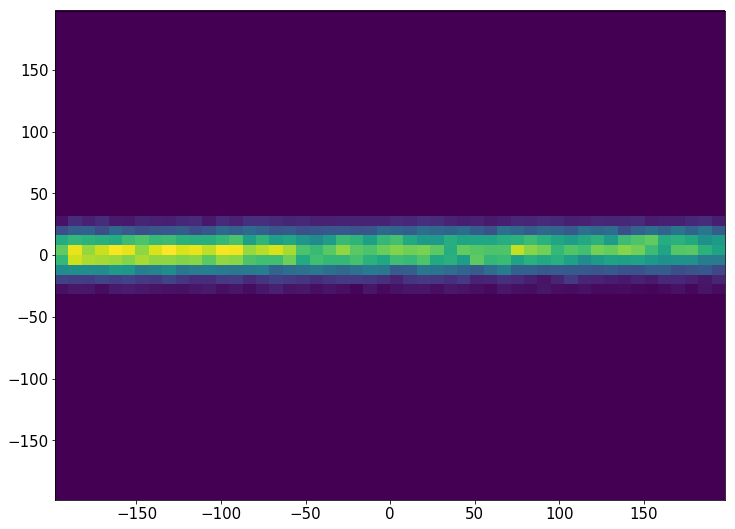

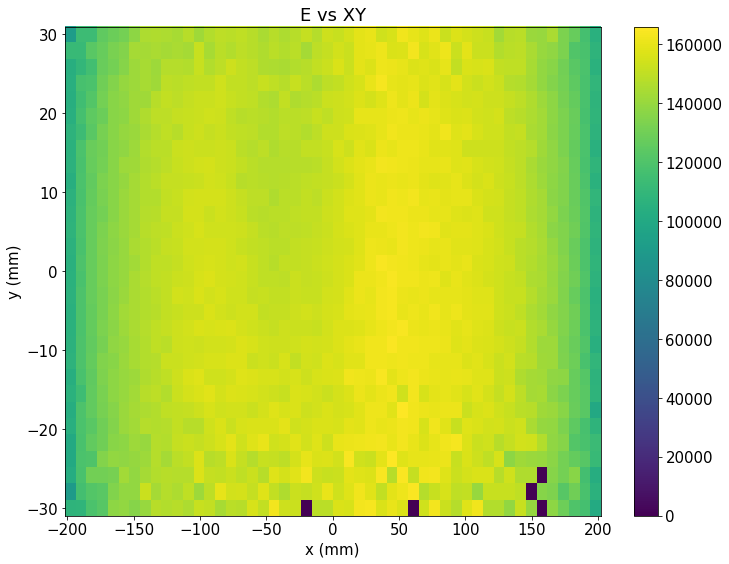

In [86]:
nx, ny = 50, 30
hist2d(Na.X.values, Na.Y.values, (50, 50), (XYrange, XYrange))
x, y, E, u_E = fitf.profileXY(Na.X.values, Na.Y.values, E_zcorr, nx, ny, XYrange, Yrange_Na)
display_matrix(x, y, E)
labels("x (mm)", "y (mm)", "E vs XY")


XYcorrNa = corrf.Correction((x, y), E, u_E, "index", index=(nx//2, ny//2))

2.82446188534
[  1.09561792e+07   1.61503559e+05   1.83463386e+03   3.88040096e+06
   1.52280445e+05   1.73166594e+03  -1.52811767e+04   2.00042427e-01
  -6.46090105e-07]
[  1.69938333e+05   2.46630456e+01   2.45489446e+01   1.43947470e+05
   4.60006037e+01   5.40207752e+01   1.90478169e+03   2.46250026e-02
   7.90561451e-08]
(Measurement(value=2.6695322443650151, uncertainty=0.035722913558725151), Measurement(value=1.2171796469873621, uncertainty=0.016287948349959613))
(Measurement(value=2.6723161642991387, uncertainty=0.037886535277899445), Measurement(value=1.1825100221372193, uncertainty=0.016764935327897964))


(0, 2840.3289093316566)

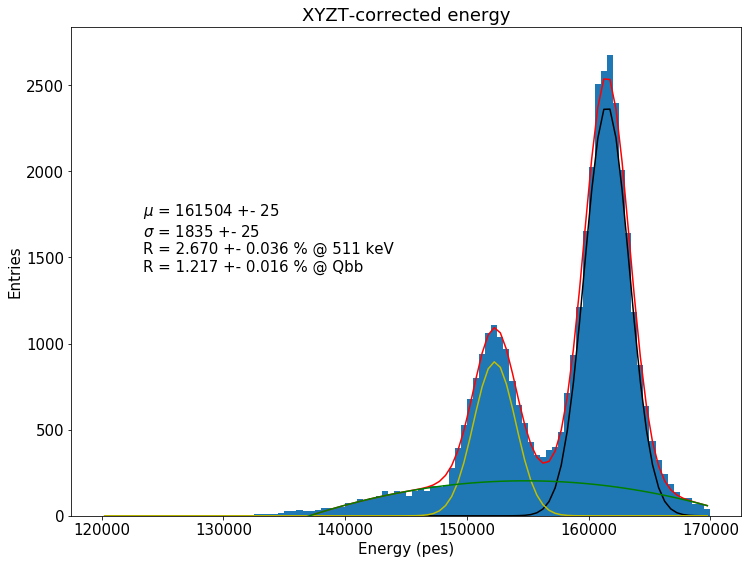

In [87]:
T      = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr = E_zcorr * XYcorrNa(Na.X.values, Na.Y.values).value * Tcorr(T).value
y, x, _ = \
hist(E_xyzcorr, 100, Narange_xyzcorr)
labels("Energy (pes)", "Entries", "XYZT-corrected energy")

fit_range = 140e3, 170e3
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2

seed = 1e5, 162e3, 1500, 1e5, 153e3, 1500, -1e5, 1e-1, -1e-3
low  = 1e1, 160e3, 1000, 1e1, 150e3, 1000, -1e8,    0, -1e-1
upp  = 1e9, 165e3, 3000, 1e8, 158e3, 3000,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=fit_range, sigma=poisson_uncertainty(y))
assert not np.any(np.isclose(f.values, seed))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0]*1.05, plt.ylim()[1]/2, gausstext(f.values, f.errors, 511))
print(f.chi2)
print(f.values)
print(f.errors)
print(resolution(f.values[:3], f.errors, 511))
print(resolution(f.values[3:], f.errors, 511 - 29.7))

plt.ylim(0)

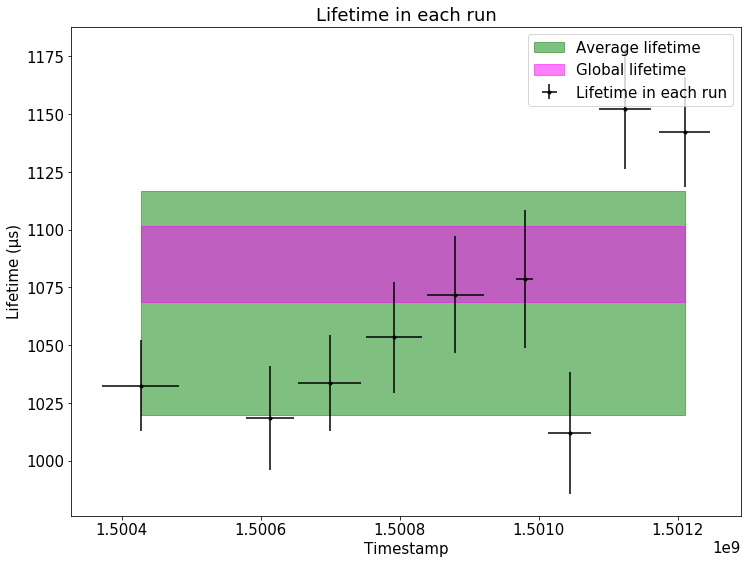

In [88]:
times       = []
u_times     = []
lifetimes   = []
u_lifetimes = []
for run_number in run_numbers:
    _fid      = dstio.load_dst(inputfilename.format(run_number), "DST", "Events")
    _fid      = _fid[_fid.R < 100]

    low_cut   =  8000 * np.exp(-0.0011*_fid.Z.values)
    high_cut  = 11000 * np.exp(-0.0008*_fid.Z.values)
    sel       = coref.in_range(_fid.S2e.values, low_cut, high_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(_fid.Z[sel], _fid.S2e[sel], 100, xrange=Zrange, yrange=Erange_raw)

    #plt.figure()
    #plt.plot(x, y, profOpt)
    #plt.plot(_fid.Z.values,  low_cut, "k.")
    #plt.plot(_fid.Z.values, high_cut, "k.")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    sel  = u_y/y > 1e-3
    f    = fitf.fit(fitf.expo, x[sel], y[sel], seed, fit_range=Zrange_LT, sigma=u_y[sel])
    assert not np.any(np.isclose(f.values, seed))
    
    #plt.plot(x, f.fn(x), fitOpt)
    #print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    #print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    #print("Chi2          = {:.2f}          ".format(f.chi2))

    #labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
    times      .append(_fid.time.mean())
    u_times    .append((_fid.time.max() - _fid.time.min())/2)
    lifetimes  .append(-f.values[1])
    u_lifetimes.append( f.errors[1])

global_lifetime   = 1085
u_global_lifetime = 16.4

plt.errorbar(times, lifetimes, u_lifetimes, u_times, ".k", label="Lifetime in each run")
average   = np.average(lifetimes, weights=u_lifetimes)
u_average = np.average((lifetimes-average)**2, weights=u_lifetimes)**0.5
plt.fill_between(times, average - u_average , average + u_average, alpha=0.5, color="green", label="Average lifetime")
plt.fill_between(times, global_lifetime - u_global_lifetime, global_lifetime + u_global_lifetime, alpha=0.5, color="magenta", label="Global lifetime")
plt.legend()
labels("Timestamp", "Lifetime (µs)", "Lifetime in each run")

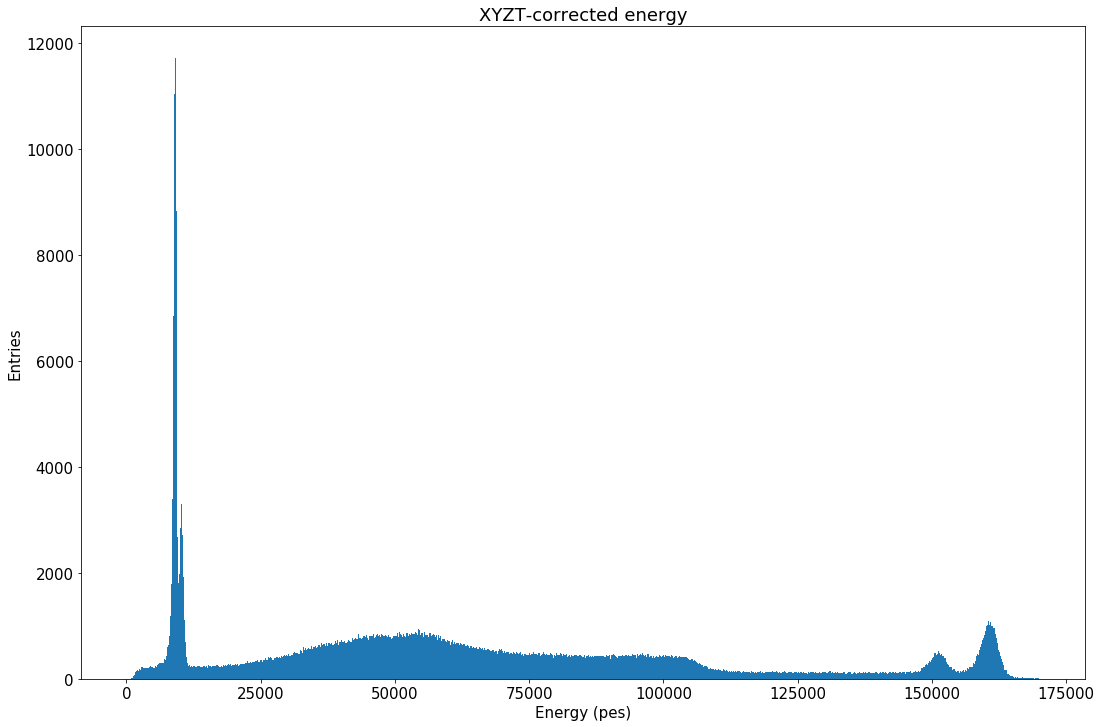

In [89]:
T              = (full.time.values - np.min(full.time.values))/60
E_xyzcorr_full = E_zcorr_full * XYcorr(full.X.values, full.Y.values).value * Tcorr(T).value

plt.figure(figsize=(18,12))
y, x, _ = \
hist(E_xyzcorr_full, 1000, (0, Narange_xyzcorr[1]), new_figure=False)
labels("Energy (pes)", "Entries", "XYZT-corrected energy")

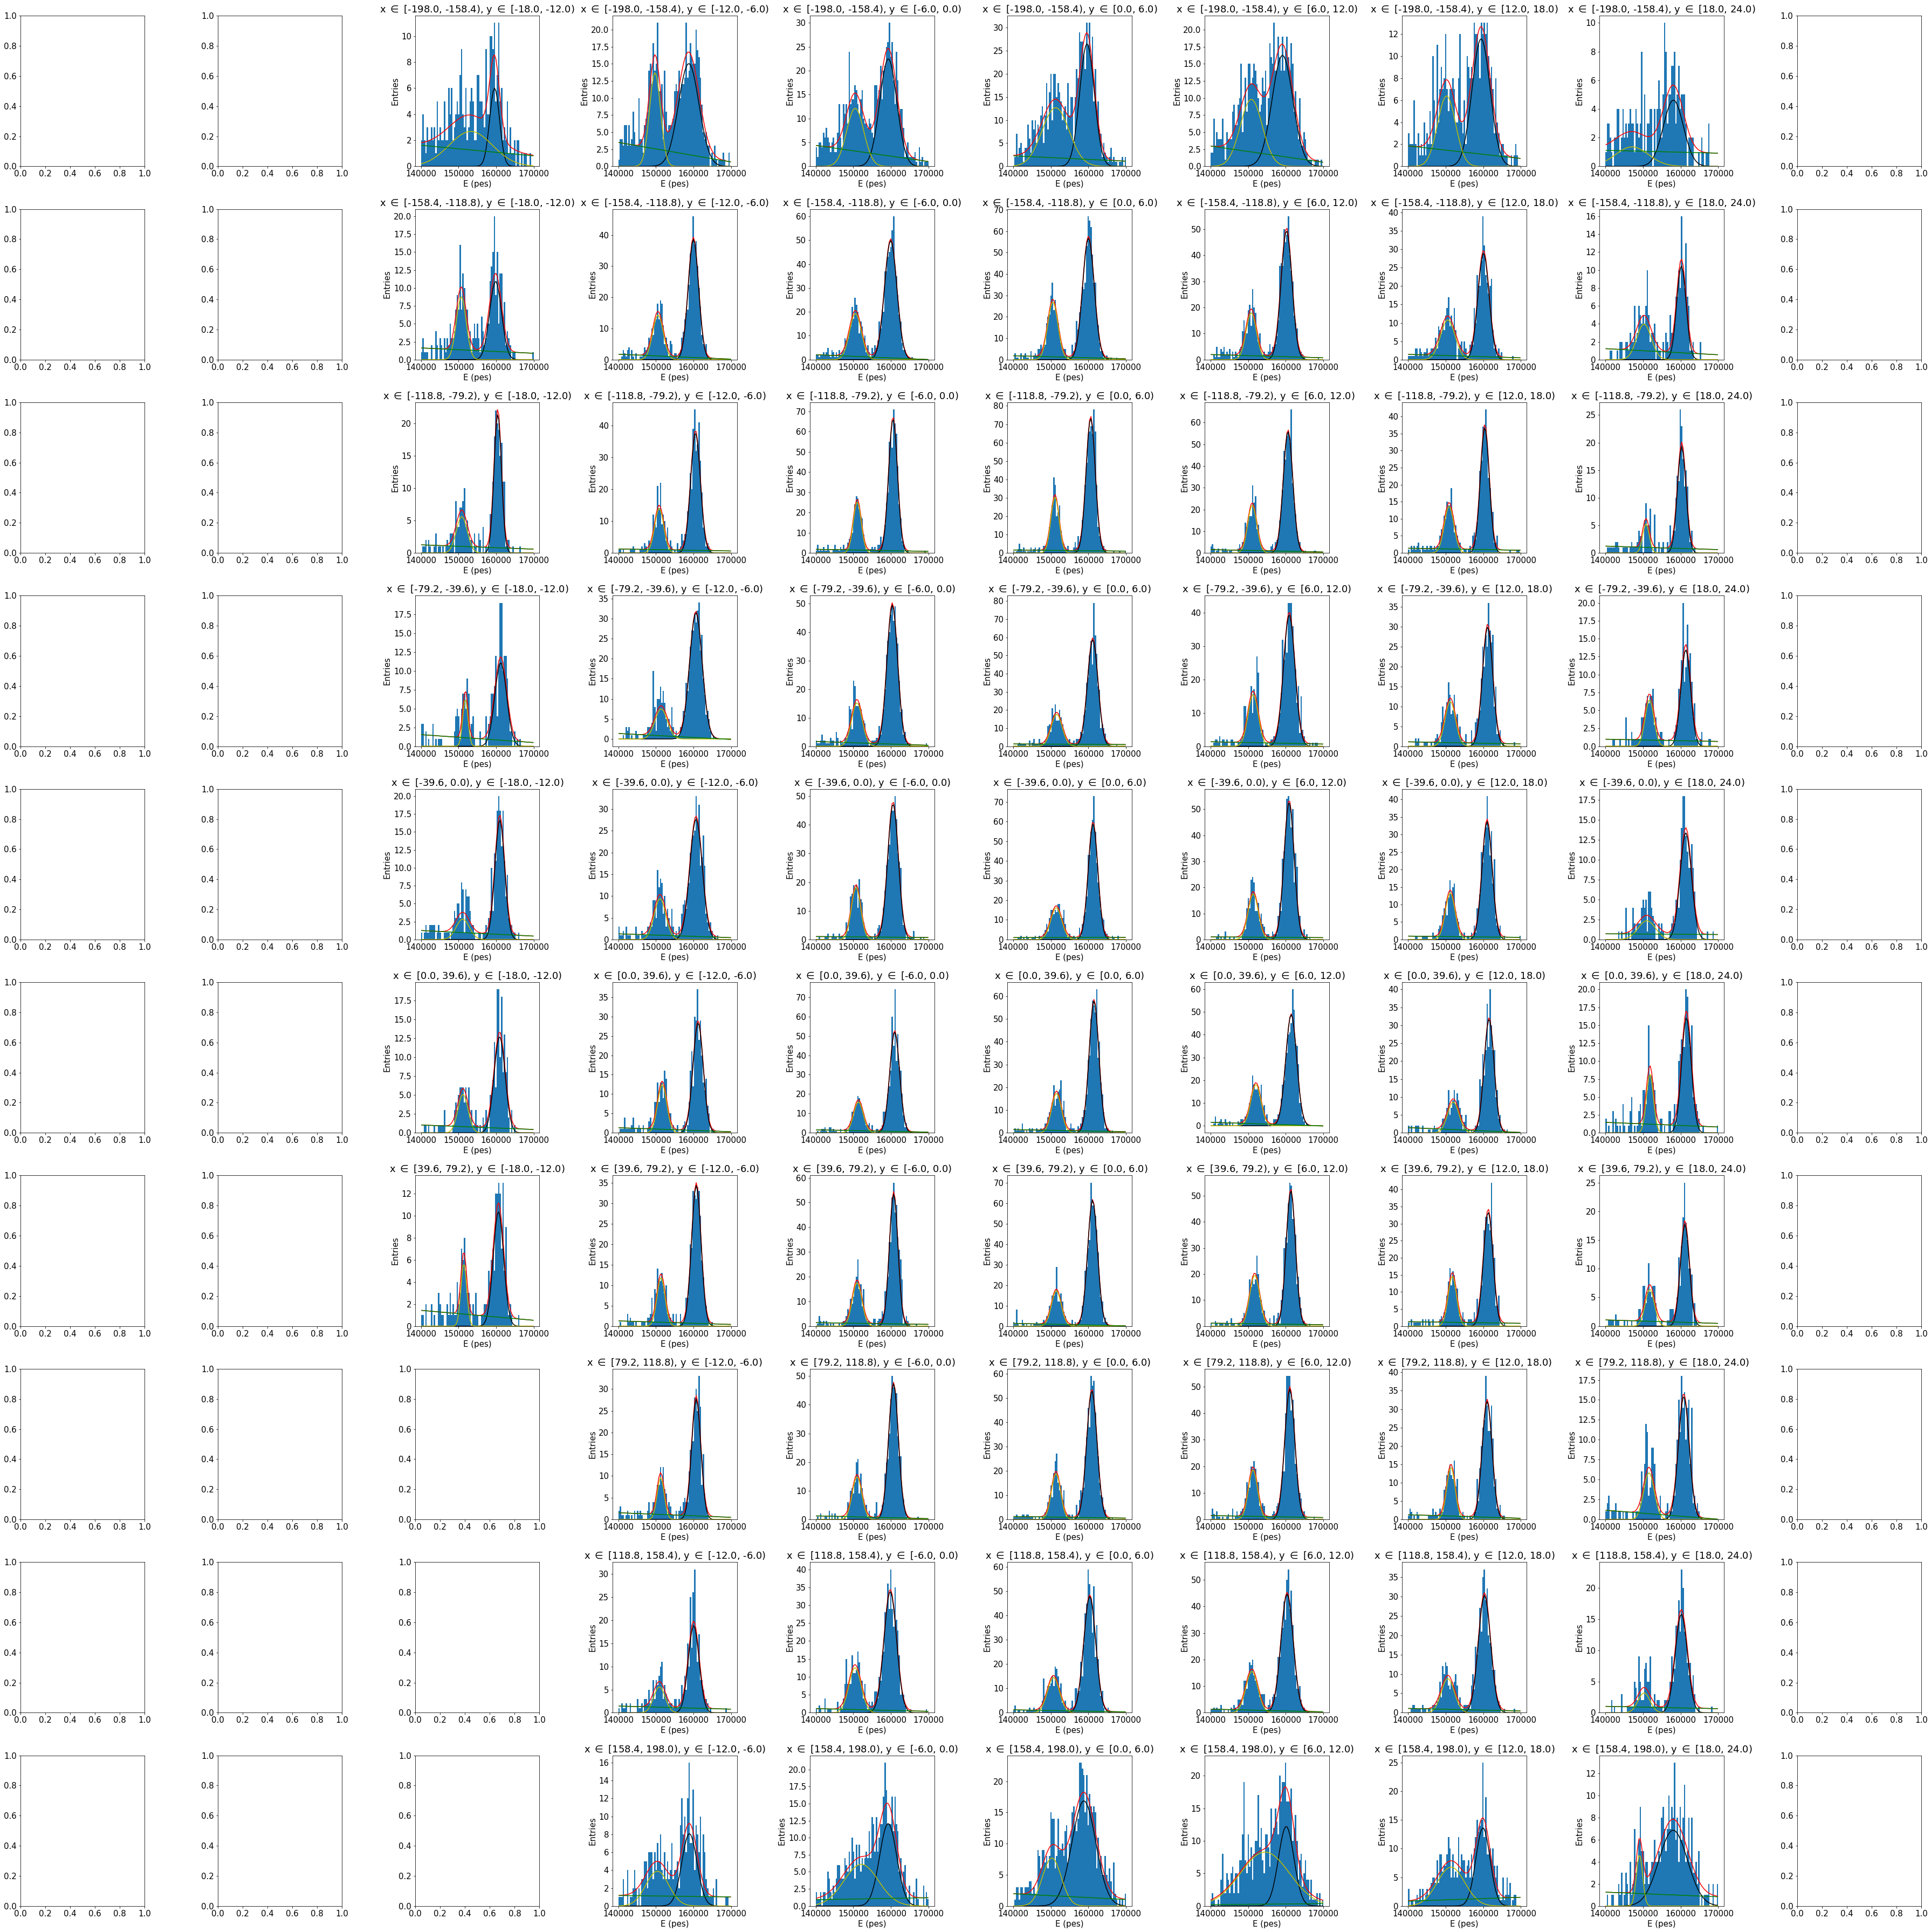

In [90]:
nx, ny = 10, 10
xbins  = np.linspace(*XYrange, nx+1)
ybins  = np.linspace(* Yrange_Na, ny+1)
Ebins  = np.linspace(140e3, 170e3, 80)

fit_range = 145e3, 178e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2#, +1e-8

T          = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr  = E_zcorr * XYcorr(Na.X.values, Na.Y.values).value * Tcorr(T).value
R_values   = np.zeros((nx, ny))
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx, 5*ny))
for i in range(nx):
    for j in range(ny):
        plt.subplot(nx, ny, i*ny + j + 1)

        sel = coref.in_range(Na.X.values, *xbins[i:i+2]) &\
              coref.in_range(Na.Y.values, *ybins[j:j+2])
        if np.count_nonzero(sel) < 200:
            continue
        
        E       = E_xyzcorr[sel]
        y, x, _ = hist(E, Ebins, new_figure=False)
        title   = "x $\in$ [{:.1f}, {:.1f}), y $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2],
                                                                              *ybins[j:j+2])
        labels("E (pes)", "Entries", title)

        f    = fitf.fit(fun, x, y, seed, sigma=poisson_uncertainty(y), maxfev=10000)
        plt.plot(x, f.fn(x), fitOpt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
        plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")        
        
        res, res_bb = resolution(f.values, f.errors, 511)
        R_values  [i, j] = res_bb.value
        u_R_values[i, j] = res_bb.uncertainty
plt.tight_layout()

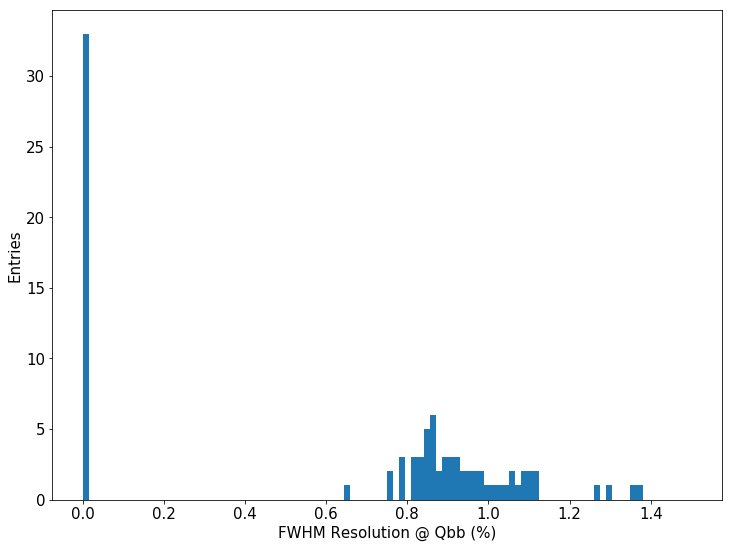

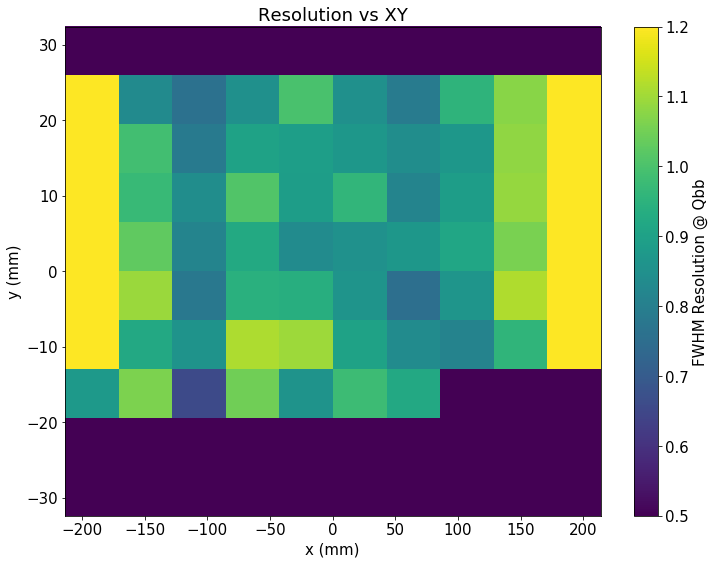

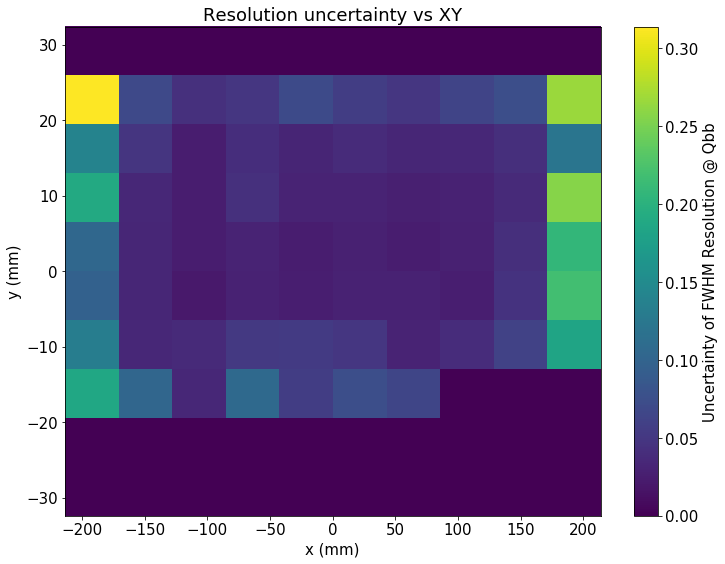

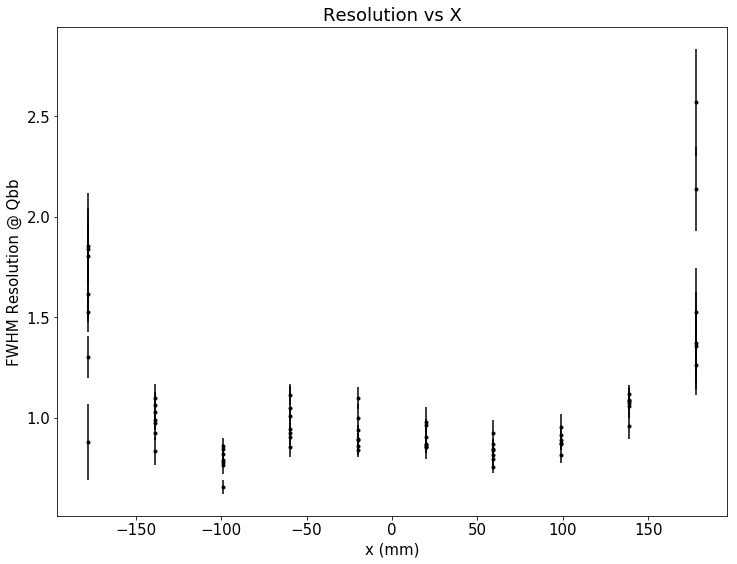

In [91]:
_x = shift_to_bin_centers(xbins)
_y = shift_to_bin_centers(ybins)

hist(R_values.flatten(), 100, (0, 1.5))
labels("FWHM Resolution @ Qbb (%)", "Entries")

_, cb = display_matrix(_x, _y,   R_values, vmin=0.5, vmax=1.2)
cb.set_label("FWHM Resolution @ Qbb")
labels("x (mm)", "y (mm)", "Resolution vs XY")

_, cb = display_matrix(_x, _y, u_R_values)
cb.set_label("Uncertainty of FWHM Resolution @ Qbb")
labels("x (mm)", "y (mm)", "Resolution uncertainty vs XY")

plt.figure()
sel = R_values.flatten() > 0
plt.errorbar(np.repeat(_x, ny)[sel], R_values.flatten()[sel], u_R_values.flatten()[sel], fmt="k.")
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs X")

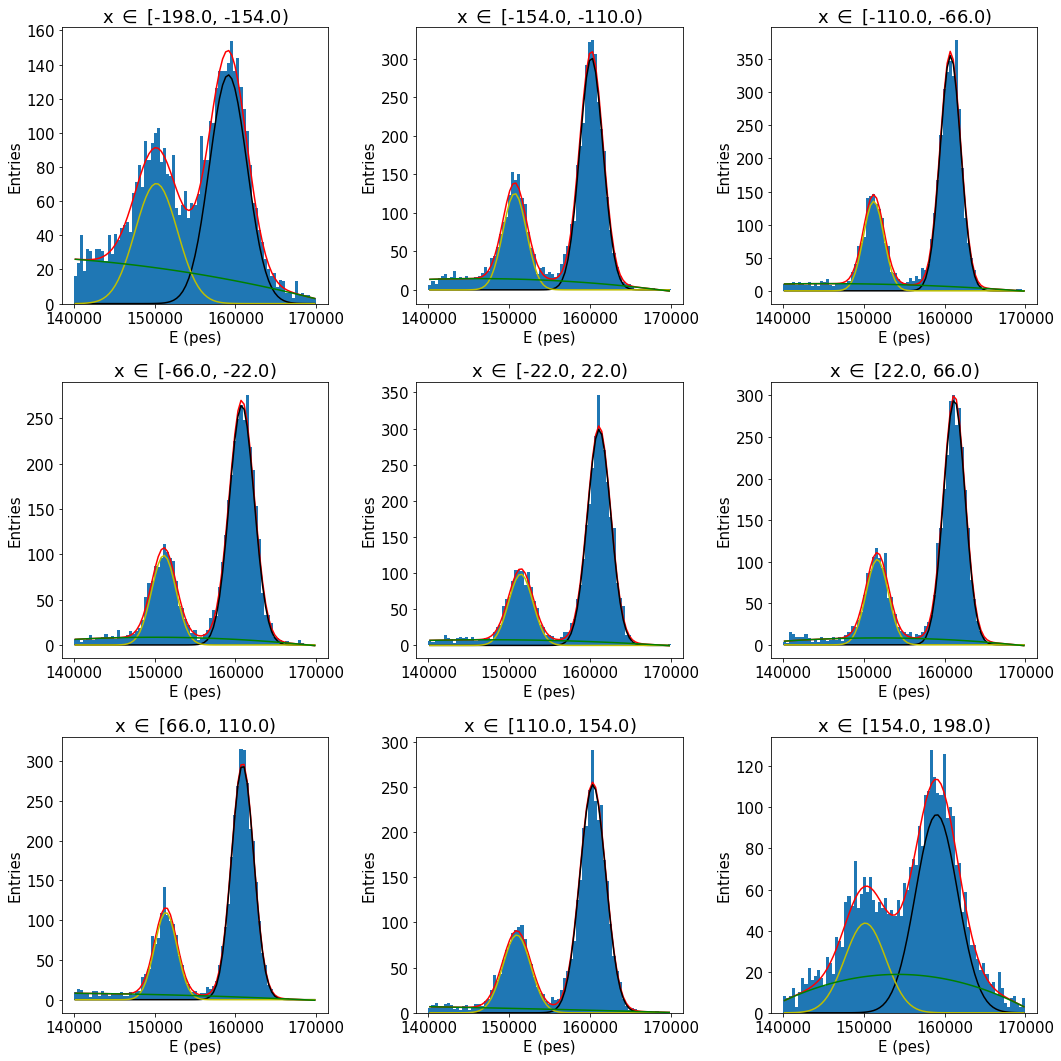

In [92]:
nx     = 9
xbins  = np.linspace(*XYrange, nx+1)
Ebins  = np.linspace(140e3, 170e3, 80)

fit_range = 140e3, 170e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
#seed      = 1e5, 160e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2
#lower     =   0, 156e3, 1e2,   0, 145e3, 1e2, 1e1, -1e-1
#upper     = 1e9, 165e3, 1e4, 1e9, 154e3, 1e4, 1e8, +1e-8

seed  = 1e5, 162e3, 1500, 1e5, 150e3, 1500, -1e5, 1e-1, -1e-7
lower = 1e1, 158e3, 1000, 1e1, 148e3, 1000, -1e8,    0, -1e-1
upper = 1e9, 165e3, 3000, 1e8, 155e3, 3000,    0, 1e+3,     0

T          = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr  = E_zcorr * XYcorr(Na.X.values, Na.Y.values).value * Tcorr(T).value
R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(Na.X.values, *xbins[i:i+2])
    if np.count_nonzero(sel) < 200:
        continue

    E       = E_xyzcorr[sel]
    y, x, _ = hist(E, Ebins, new_figure=False)
    title   = "x $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
    labels("E (pes)", "Entries", title)
#    continue
    f    = fitf.fit(fun, x, y, seed, sigma=poisson_uncertainty(y), bounds=(lower, upper))
    plt.plot(x, f.fn(x), fitOpt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
    plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
    plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")        

    res, res_bb   = resolution(f.values, f.errors, 511)
    R_values  [i] = res_bb.value
    u_R_values[i] = res_bb.uncertainty
plt.tight_layout()

[ 1.5684694   0.96178557  0.8467101   1.02505671  0.95999622  0.88833125
  0.91568812  1.06766114  1.75867802]


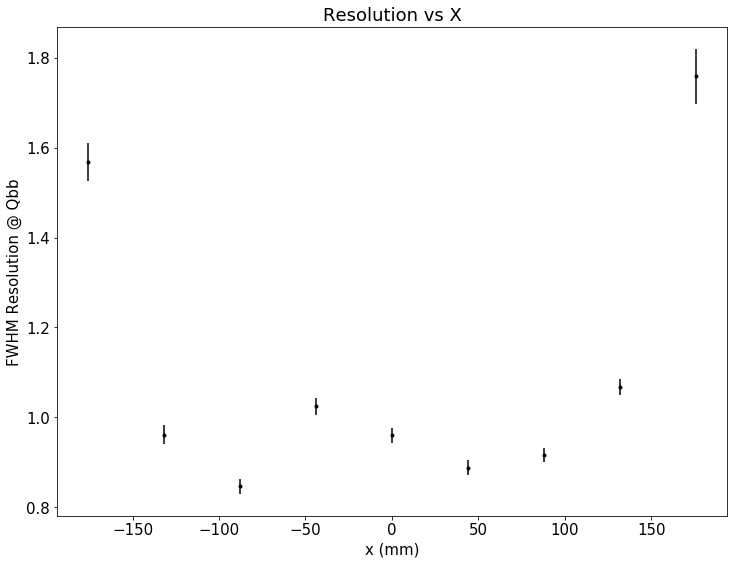

In [93]:
_x = shift_to_bin_centers(xbins)
print(R_values)
plt.errorbar(_x, R_values, u_R_values, fmt="k.")
#plt.ylim(0.5, 1.25)
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs X")

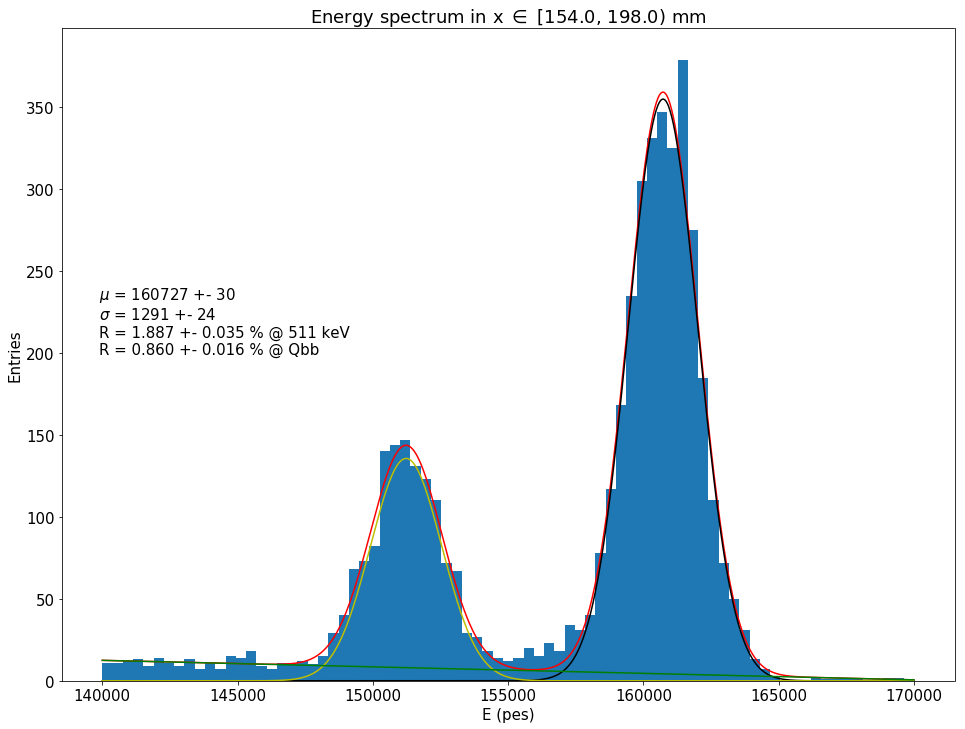

In [94]:
fit_range = 140e3, 170e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 160e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2
lower     =   0, 156e3, 1e2,   0, 145e3, 1e2, 1e1, -1e-1
upper     = 1e9, 165e3, 1e4, 1e9, 154e3, 1e4, 1e8, +1e-8

plt.figure(figsize=(16,12))
y, x, _ = hist(E_xyzcorr[coref.in_range(Na.X.values, *xbins[2:4])], Ebins, new_figure=False)

f = fitf.fit(fun, x, y, seed, sigma=poisson_uncertainty(y), bounds=(lower, upper))
x = np.linspace(*fit_range, 1000)
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0] * 1.01, plt.ylim()[1]/2, gausstext(f.values, f.errors, 511))

labels("E (pes)", "Entries", "Energy spectrum in {} mm".format(title))

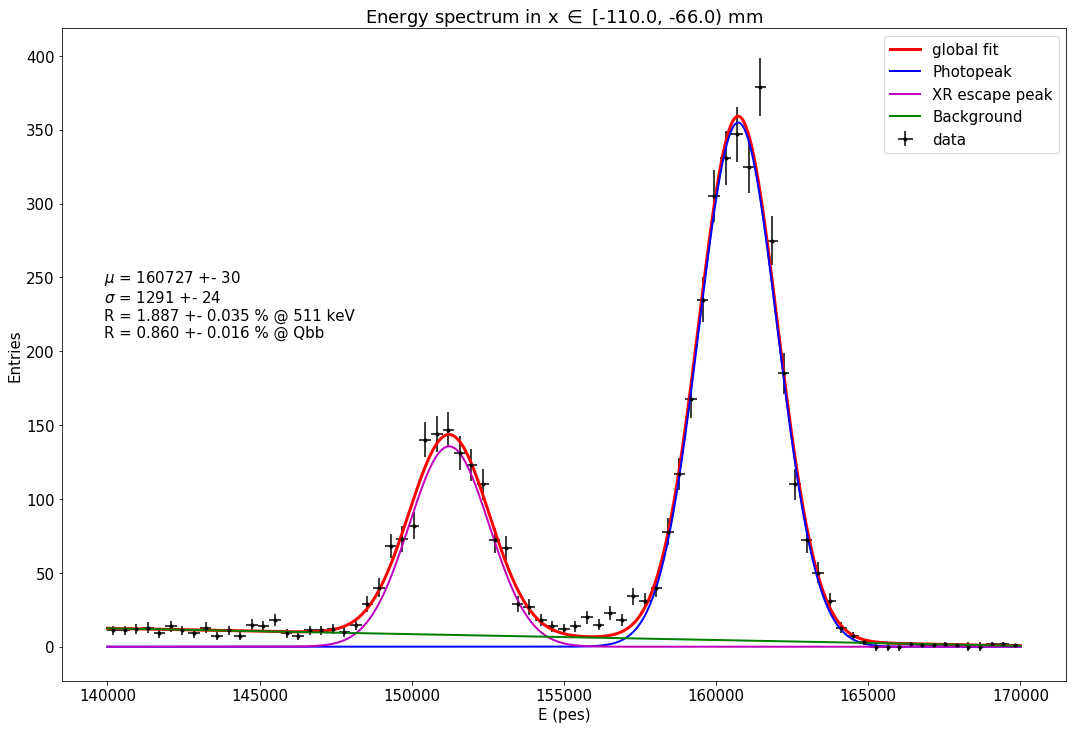

In [95]:
fit_range = 140e3, 170e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 160e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2
lower     =   0, 156e3, 1e2,   0, 145e3, 1e2, 1e1, -1e-1
upper     = 1e9, 165e3, 1e4, 1e9, 154e3, 1e4, 1e8, +1e-8

plt.figure(figsize=(18,12))
#y, x, _ = hist(E_xyzcorr[coref.in_range(Na.X.values, *xbins[2:4])], Ebins, new_figure=False)
y, x = np.histogram(E_xyzcorr[coref.in_range(Na.X.values, *xbins[2:4])], Ebins)
u_y  = poisson_uncertainty(y)
x    = shift_to_bin_centers(x)

plt.errorbar(x, y, u_y, np.diff(Ebins)*0.5, "k.", label="data")
f = fitf.fit(fun, x, y, seed, sigma=u_y, bounds=(lower, upper))
x = np.linspace(*fit_range, 1000)
plt.plot(x, f   .fn     (x                ), "r-", lw=3, label="global fit")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "b-", lw=2, label="Photopeak")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "m-", lw=2, label="XR escape peak")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-", lw=2, label="Background")

plt.text(plt.xlim()[0] * 1.01, plt.ylim()[1]/2, gausstext(f.values, f.errors, 511))
plt.legend()
title   = "x $\in$ [{:.1f}, {:.1f})".format(*xbins[2:4])
labels("E (pes)", "Entries", "Energy spectrum in {} mm".format(title))

In [117]:
T          = (full.time.values - full.time.values.min())/60
E_xyztcorr =  full.S2e.values * Zcorr(full.Z.values).value * XYcorr(full.X.values, full.Y.values).value * Tcorr(T).value

XRsel = coref.in_range(E_xyztcorr, 6e3, 12e3)
XR    = full[XRsel]

In [118]:
XR1_fit_seed = 9e3
XR2_fit_seed = 10e3

In [119]:
global_fit_draw_opt = "b-"
peak_1_fit_draw_opt  = "r-"
peak_2_fit_draw_opt  = "b-"
bkg_fit_draw_opt     = "g-"

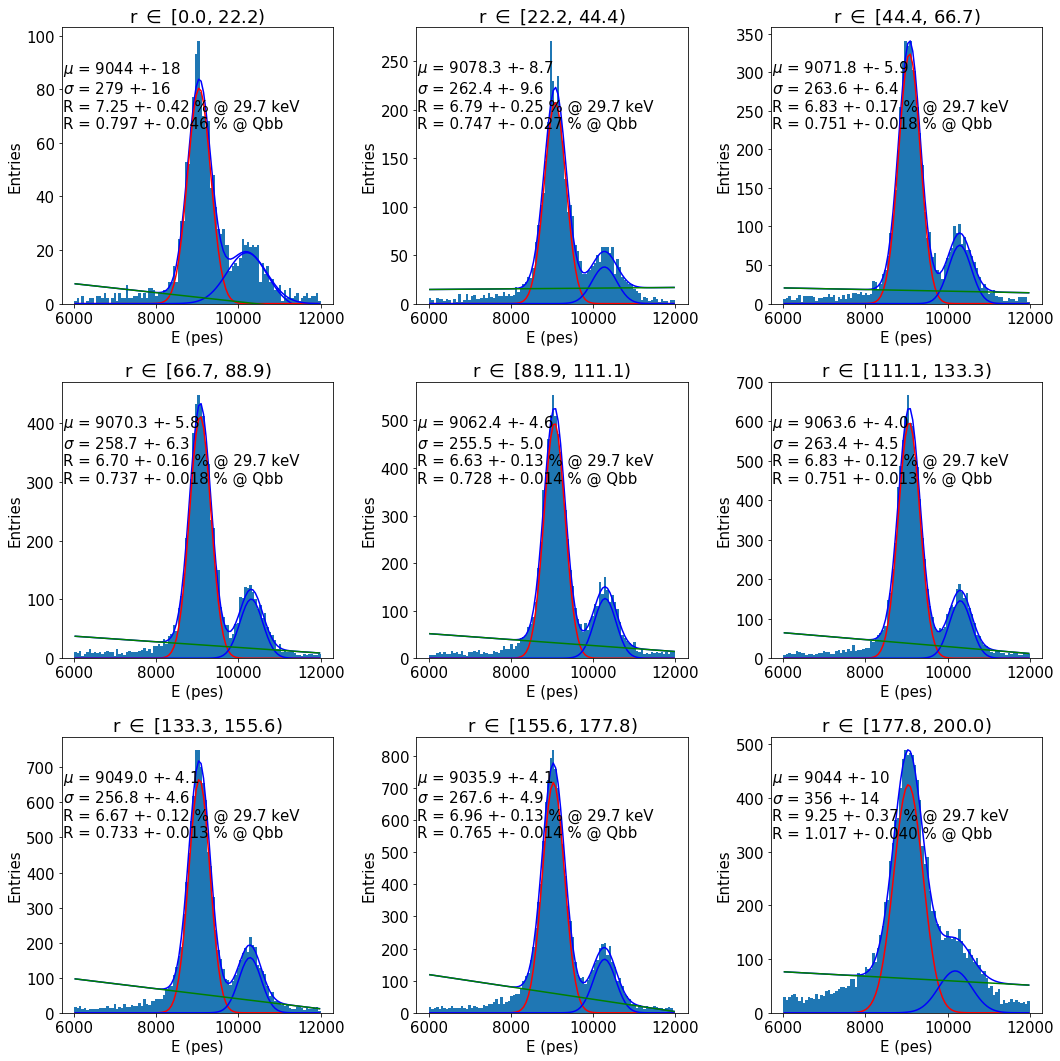

In [120]:
nx     = 9
xbins  = np.linspace(0, 200, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(XR)
#seed = 1e5, 9e3, 1e2, 1e4, 10e3, 1e2, 1e2, -1e-2
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10 , -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)    , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.06,  np.mean(y)*1e3, +1e+1

R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(full.R.values, *xbins[i:i+2]) & XRsel
    if np.count_nonzero(sel) < 200:
        continue

#    try:
    E       = E_xyztcorr[sel]
    y, x, _ = hist(E, 100, (6e3, 12e3), new_figure=False)
    title   = "r $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
    labels("E (pes)", "Entries", title)

    f = fitf.fit(fun, x, y, seed, fit_range=(8200, 11e3), sigma=poisson_uncertainty(y),
                 bounds=(low, upp),
                 maxfev=10000)

    assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
    assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
    assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

    plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
    plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
    plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
             gausstext(f.values, f.errors, 29.7))
    plt.ylim(0)

    res, res_bb   = resolution(f.values, f.errors, 29.7)
    R_values  [i] = res_bb.value
    u_R_values[i] = res_bb.uncertainty
#    except:
#        continue
plt.tight_layout()

[ 0.79745216  0.74672119  0.75063002  0.73666835  0.72829699  0.75061399
  0.7330576   0.76510418  1.01728139]


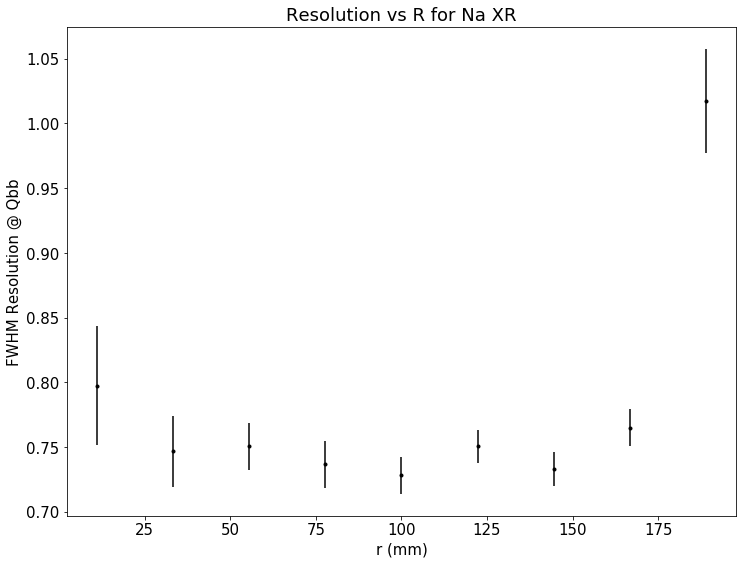

In [122]:
_x = shift_to_bin_centers(xbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_x[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("r (mm)", "FWHM Resolution @ Qbb", "Resolution vs R for Na XR")

AssertionError: [False False False False False  True  True False]

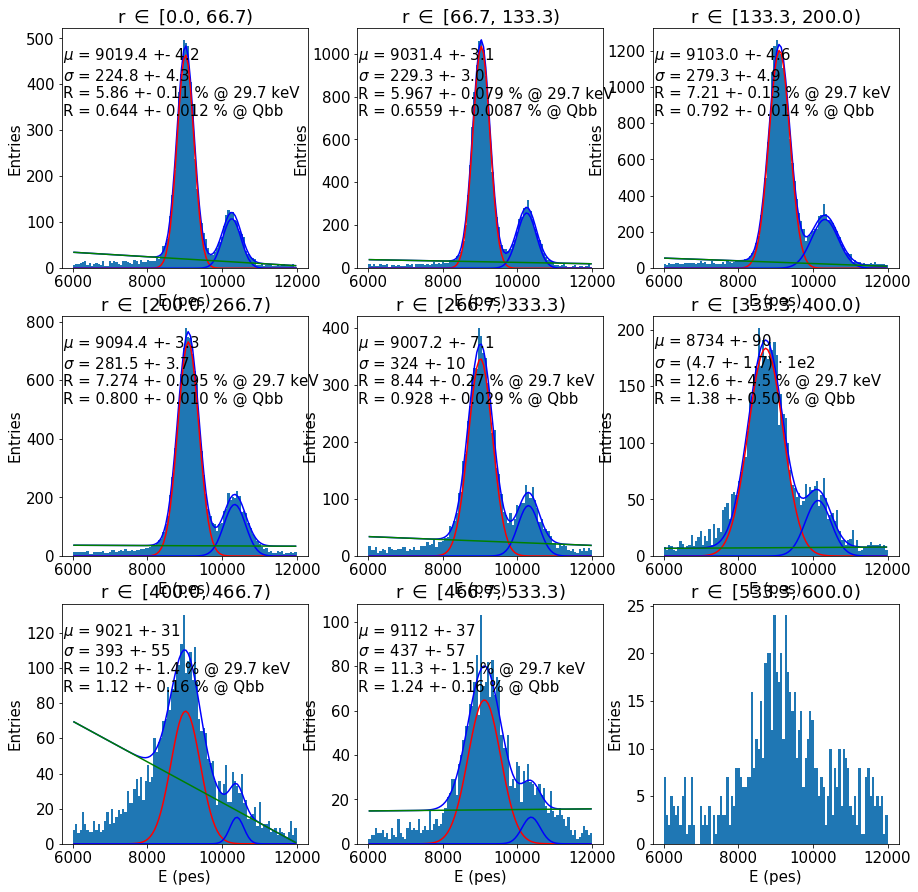

In [124]:
nx     = 9
xbins  = np.linspace(0, 600, nx+1)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = len(XR)
#seed = 1e5, 9e3, 1e2, 1e4, 10e3, 1e2, 1e2, -1e-2
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10 , -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)    , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.09,  np.mean(y)*1e3, +1e+1

R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(full.Z.values, *xbins[i:i+2]) & XRsel
    if np.count_nonzero(sel) < 200:
        continue

#    try:
    E       = E_xyztcorr[sel]
    y, x, _ = hist(E, 100, (6e3, 12e3), new_figure=False)
    title   = "r $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
    labels("E (pes)", "Entries", title)

    f = fitf.fit(fun, x, y, seed, fit_range=(8200, 11e3), sigma=poisson_uncertainty(y),
                 bounds=(low, upp),
                 maxfev=10000)

    assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
    assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
    assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

    plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
    plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
    plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
             gausstext(f.values, f.errors, 29.7))
    plt.ylim(0)

    res, res_bb   = resolution(f.values, f.errors, 29.7)
    R_values  [i] = res_bb.value
    u_R_values[i] = res_bb.uncertainty
#    except:
#        continue
plt.tight_layout()

[ 0.64393841  0.65592497  0.79245441  0.79961155  0.92822323  1.38152636
  1.12417538  1.24010357  0.        ]


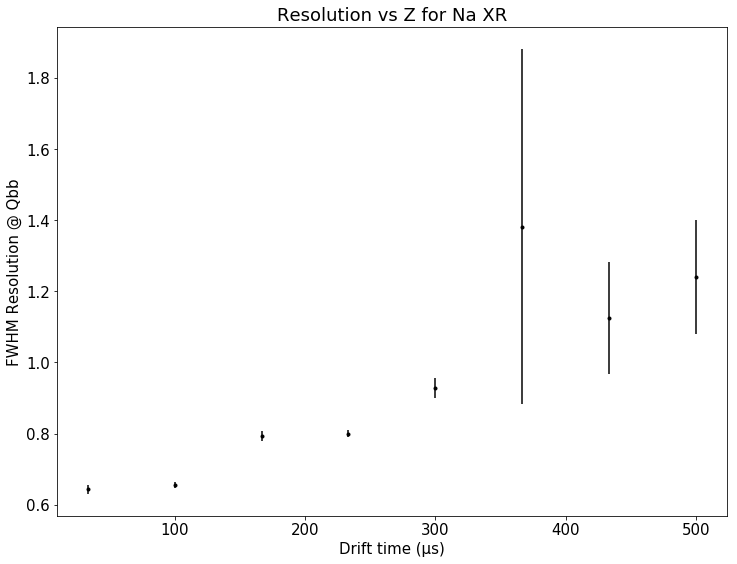

In [125]:
_x = shift_to_bin_centers(xbins)

sel = R_values > 0
print(R_values)

plt.errorbar(_x[sel], R_values[sel], u_R_values[sel], fmt="k.")
labels("Drift time (µs)", "FWHM Resolution @ Qbb", "Resolution vs Z for Na XR")